# Exploração de dados das redes sociais de candidatos

[Voltar ao Índice](00_indice.ipynb)

Vamos explorar os dados disponibilizados pelo TSE acerca das redes sociais dos candidatos e candidatas.

**ATTENTION:** This notebook refers to data that is not present in the project, due to its size. This data can be found at <https://dadosabertos.tse.jus.br/dataset/>

In [18]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from glob import glob
from pathlib import Path

import src.xavy.explore as xe
import src.xavy.dataframes as xd
import src.xavy.utils as xu
import src.xavy.text as xt
import src.xavy.test as xtest
import src.xavy.plots as xpl

import src.xavy.tse as tse
import src.xavy.twitter as tw
import src.xavy.data_retriever as xz

## Funções

### Declarações

In [2]:
def regex_selector(series, regex, exists=True, case=True, verbose=False):
    """
    Check is a regular expression is present in each
    element of a Series.
    
    Parameters
    ----------
    series : Series of str
        The texts to look for the regular expression.
    regex : str
        The regular expression to look for.
    exists : bool
        If False, look for texts that do NOT contain
        `regex`. Otherwise, look for texts that do 
        contain it.
    case : bool
        Whether to do a case-sensitive search or not.
    verbose : bool
        If True, print the selection criteria used.
        
    Returns
    -------
    selector : Series
        Boolean series specifying if each text in 
        `series` obeys the specified selection or 
        not.
    """
    
    # Print criteria if requested:
    if verbose is True:
        if exists is False:
            print('Not ', end='')
        print("'{}'".format(regex), end='')
        if case is False:
            print(' (any case)')
        else:
            print('')
    
    # Create selector and return:
    selector = series.str.contains(regex, case=case)
    if exists is False:
        return ~selector
    else:
        return selector    

In [3]:
def strip_col_names(df):
    """
    Remove surrounding whitespaces from the column
    names of a DataFrame `df`, in place.
    """
    cols = df.columns
    assert len(cols) == len(set(cols)), 'Existem colunas duplicadas'
    col_std = dict(zip(cols, cols.str.strip()))
    df.rename(col_std, axis=1, inplace=True)
    cols = df.columns
    assert len(cols) == len(set(cols)), 'Existem colunas duplicadas após limpeza'

In [4]:
def check_columns(df, expected_cols, expected_dtypes):
    """
    Check if `df` DataFrame columns are the 
    expected ones, and print the differences, 
    if any. Return False if any problem is 
    found, True otherwise.
    
    Parameters
    ----------
    df : DataFrame
        DataFrame whose columns should be 
        checked.
    expected_cols : list
        Expected names of the columns.
    expected_dtypes : 
    """

    # Security check:
    assert len(expected_cols) == len(expected_dtypes)
    
    # Starting variables:
    ok = True
    cols = df.columns
    expected_set = set(expected_cols)
    input_set = set(cols)

    # Colunas faltando:
    missing_set = expected_set - input_set
    if len(missing_set) > 0:
        ok = False
        print('!! As seguintes colunas estão faltando: {}'.format(missing_set))

    # Colunas novas:
    extra_set = input_set - expected_set
    if len(extra_set) > 0:
        ok = False
        print('!! As seguintes colunas não eram esperadas: {}'.format(extra_set))
    
    # Ordem das colunas:
    if input_set == expected_set:
        if (np.array(cols) != np.array(expected_cols)).any():
            ok = False
            print('!! A ordem das colunas está diferente.')
    
    # Tipo das colunas:
    if ok is True:
        expected_series = pd.Series(expected_dtypes, index=expected_cols)
        diff_dtype = (expected_series != df.dtypes)
        if diff_dtype.any() > 0:
            ok = False
            diff_cols = expected_series.loc[diff_dtype]
            print('!! Data type das colunas {} deveriam ser {} mas são {}.'.format(list(diff_cols.index), list(diff_cols.values), list(df.dtypes.loc[diff_dtype].values)))
            
    
    return ok

In [5]:
def add_platform_onehot(redes_df, redes_regex, website_regex, arroba_regex, url_col='DS_URL'):
    """
    Add dummy columns to DataFrame that 
    specify if a platform is mentioned,
    in place.
    
    Parameters
    ----------
    redes_df : DataFrame
        DataFrame containing a column named
        `url_col` that may contain a 
        reference to a platform present in 
        `redes_regex` keys.
    redes_regex : dict
        A dict from the platform name (str)
        to a regex (str) used to identify 
        the platform in the strings under 
        `url_col` column.
    website_regex : str
        Regex that identifies a website. Only
        rows that do not match any regexes from
        `redes_regex` are tested for a website.
    arroba_regex : str
        Regex that identifies a 'user-like' 
        entry that starts with @. Only rows 
        that do not match any regexes above are 
        tested for a website.        
    url_col : str
        Columns in `redes_df` that may 
        mention a platform.
    
    Returns
    -------
    redes_df : DataFrame
        The input DataFrame with extra
        columns (`redes_df` is modified).
    """
    
    # Prepare data:
    series = redes_df[url_col]
    series = series.str.strip()
    
    # Add dummy columns:
    for key in redes_regex.keys():
        redes_df[key] = regex_selector(series, redes_regex[key], case=False).astype(int)
    
    # Add column for website: 
    redes_df['website'] = 0
    is_website = regex_selector(series, website_regex, case=False)
    no_redes   = (redes_df[redes_regex.keys()] == 0).all(axis=1)
    redes_df.loc[is_website & no_redes, 'website'] = 1
    
    # Add column for @:
    redes_df['arroba'] = 0
    is_arroba  = regex_selector(series, arroba_regex, case=False)
    no_redes   = (redes_df[list(redes_regex.keys()) + ['website']] == 0).all(axis=1)
    redes_df.loc[is_arroba & no_redes, 'arroba'] = 1    
    
    # Remaining are users:
    redes_df['usuario'] = 0
    no_redes   = (redes_df[list(redes_regex.keys()) + ['website', 'arroba']] == 0).all(axis=1)
    redes_df.loc[no_redes, 'usuario'] = 1    

    
    return redes_df

In [6]:
def load_tse_social_data(path, expected_cols, expected_dtypes):
    """
    Load, clean and check TSE CSV file on 
    candidates' social media.
    
    Parameters
    ----------
    path : str
        Path to the TSE CSV file.
    expected_cols : list of str
        Names of the columns in the CSV file,
        to double check.
    expected_dtypes : list of numpy dtypes
        Data types of the columns in the CSV 
        file, to double check.
    
    Returns
    -------
    redes_df : DataFrame
        The input data with the column 
        names stripped from whitespaces.
    """
    
    # Load:
    redes_df = tse.load_tse_raw_data(path)
    # Clean:
    strip_col_names(redes_df)
    # Checks:
    assert check_columns(redes_df, expected_cols, expected_dtypes)
    return redes_df

In [7]:
def join_cand_redes(cand_df, redes_df, cand_cols):
    """
    Join candidates' information into list 
    of networks.
    
    Parameters
    ----------
    cand_df : DataFrame
        Information about the candidates. Each
        candidate is identified by column
        'SQ_CANDIDATO'.
    redes_df : DataFrame
        Social networks of the candidates. Each
        candidate is identified by column
        'SQ_CANDIDATO' and can have more than 
        one network, listed in different rows.
    cand_cols : list of str
        Columns from `cand_df` to be used. 
        Each 'SQ_CANDIDATO' must have only one
        row.
    
    Returns
    -------
    full_df : DataFrame
        Same as `redes_df` but with the 
        candidates' information from `cand_df`
        joined.
    """
    
    # Seleciona apenas uma linha por candidato:
    id_df = cand_df[cand_cols].drop_duplicates()
    # Seleciona colunas das redes:
    pos = np.argwhere(redes_df.columns == 'DS_URL')[0][0] - 1
    rd_df = redes_df.set_index('SQ_CANDIDATO').iloc[:, pos:]

    # Junta as tabelas:
    full_df = id_df.join(rd_df, on='SQ_CANDIDATO', how='right')
    assert len(full_df) == len(redes_df), 'len(redes_df) = {} enquanto que len(full_df) = {}. Deveriam ser iguais.'.format(len(redes_df), len(full_df))
    
    return full_df

In [8]:
def platform_use_by_cand(cand_df, redes_df, redes_cols):
    """
    Build DataFrame about whether a candidate uses 
    a platform or not.
    
    Parameters
    ----------
    cand_df : DataFrame
        Information about each candidate (one 
        candidate per row), identified by 
        'SQ_CANDIDATO' column.
    redes_df : DataFrame
        Platforms used by the candidates, each
        row is identified by 'SQ_CANDIDATO' and
        'NR_ORDEM' (platform number).
    redes_cols : list of str
        Names of columns in `redes_df` that 
        contains the dummy variables specifying 
        if the platform in 'DS_URL' column is 
        the one in question.
        
    Returns
    -------
    use_df : DataFrame
        A table informing which platforms are 
        used by each candidate, one row per 
        candidate identified by 'SQ_CANDIDATO'.
    """
    
    # Junta info dos candidatos com redes declaradas (vários candidatos não declararam rede nenhuma):
    use_df = cand_df.join(redes_df.groupby('SQ_CANDIDATO')[redes_cols].sum().clip(upper=1), on='SQ_CANDIDATO', how='left')
    assert len(use_df) == len(cand_df)

    # Preenche quem não declarou com "nenhuma":
    use_df['nenhuma'].fillna(1, inplace=True)
    for col in filter(lambda s: s != 'nenhuma', redes_cols):
        use_df[col].fillna(0, inplace=True)

    # Usa números inteiros:
    use_df[redes_cols] = use_df[redes_cols].astype(int)
    
    return use_df

In [9]:
def plot_platform_use_by_group(use_df, criterium, cat_order=None, min_frac=5, rotate=False, show=True, fig_width=12):
    """
    Plot the fraction of candidates that declared
    use of each platform.
    
    Parameters
    ----------
    use_df : DataFrame
        Table that specifies which platforms
        each candidate uses (one row per 
        candidate).
    criterium : str
        Column in `use_df` that categorizes 
        the candidates.
    cat_order : list of str or None
        Categories in column `criterium` to 
        plot, in the required order.
    min_frac : float
        Minimum platform percentage of use 
        so the platform appears on the plot,
        from 0 to 100.
    show : bool
        Whether to call `pl.show()` or not.
    """
    
    # Use all categories if none is specified:
    if cat_order is None:
        cat_order = use_df[criterium].drop_duplicates()

    # Get percentages in each group:
    use_by_group = use_df.groupby(criterium)[redes_cols].mean() * 100

    pl.figure(figsize=(fig_width, 4))
    pl.subplot(1,2,1)

    # Plot number of entries:
    use_df[criterium].value_counts().loc[cat_order].plot(kind='bar')
    pl.ylabel('# candidatos')
    pl.yscale('log')
    pl.xlabel(criterium)
    pl.legend()

    # Plot percentages of platform uses:
    pl.subplot(1,2,2)
    xpl.multiple_bars_plot(use_by_group.loc[cat_order, use_by_group.max() > min_frac])
    pl.ylabel('% dos candidatos')
    if rotate is True:
        pl.xticks(rotation=90)
        #pl.gca().tick_params(axis='x', labelrotation=90)
    pl.legend()

    if show is True:
        pl.show()

In [10]:
def load_n_eleitores_by_ue(path, ue_col, qt_col='QT_ELEITORES_PERFIL'):
    """
    Load cleaned eleitorado data and aggregate it 
    to the unidade eleitoral level.
    
    Parameters
    ----------
    path : str
        Path to the already cleaned CSV file with
        eleitorado counts under each category.
    ue_col : str
        Name of the column that specifies the 
        unidade eleitoral (e.g. 'CD_MUNICIPIO' or
        'SG_UF').
    qt_col : str
        Name of the column with the number of 
        eleitores, to sum over.
    
    Returns
    -------
    series : Total number of eleitores in each 
    unidade eleitoral described in `ue_col`.
    """
    
    df = pd.read_csv(Path(path), low_memory=False, usecols=[ue_col, qt_col])
    series = df.groupby(ue_col)[qt_col].sum()
    
    return series

In [11]:
def build_bem_features(df, index_cols):
    """
    Aggregate candidate's wealth described in `df` (DataFrame, with TSE information)
    and returns a DataFrame with features as columns and
    'ANO_ELEICAO', 'SG_UF', 'SQ_CANDIDATO' as indices.
    """
    # Group data by candidate:
    grouped_by_cand = df.groupby(index_cols)

    # Build features DataFrame:
    bem_features = pd.DataFrame()
    bem_features['NUMERO_BENS']      = grouped_by_cand.size()
    bem_features['VALOR_TOTAL_BENS'] = grouped_by_cand['VR_BEM_CANDIDATO'].sum()
    
    return bem_features


def load_bem_build_features(path_pattern, index_cols=['ANO_ELEICAO', 'SG_UF', 'SQ_CANDIDATO']):
    """
    Loads all 'bem_candidato' files that match the `path_pattern` (str),
    concatenate them and build aggregated features for each candidate. 
    Returns a DataFrame with indices 'ANO_ELEICAO', 'SG_UF', 'SQ_CANDIDATO'
    and features as columns.
    """
    file_list = sorted(glob(str(Path(path_pattern))))
    df = pd.concat([build_bem_features(pd.read_csv(f), index_cols) for f in file_list])
    #df = pd.concat([pd.read_csv(f) for f in file_list])
    
    return df

In [12]:
def extract_twitter_username(series, lower=True):
    """
    Given a Series that contains the URL 
    or the username of twitter accounts,
    extract the username.
    
    If `lower` is True, return lower case
    username (Twitter usernames are not 
    case-sensitive).
    
    Returns a series with same index as 
    the input. NaN is returned when no
    unsername is found.
    """
    
    #cleaned = series
    cleaned  = series.str.replace(r'https?:/+(?:www\.)?twitter\.com/https?:/*', 'https://', regex=True)
    cleaned  = cleaned.str.replace(r'https?:/+(?:www\.)?twitter\.com/www.twitter.com*', 'https://www.twitter.com', regex=True)
    cleaned  = cleaned.str.replace(r'www\.twitter/', 'www.twitter.com/', regex=True)
    username =  cleaned.str.extract('(?:(?:t[uw]{1,}[ei]{1,}t{1,}w?e{1,}r?|tweet)\.com(?:\.br)?/+[@:]?|@)(\w+)', flags=re.IGNORECASE)[0]
    if lower is True:
        username = username.str.lower()
    
    return username

In [13]:
def extract_instagram_username(series, lower=True):
    """
    Given a Series that contains the URL 
    or the username of instagram accounts,
    extract the username.
    
    If `lower` is True, return lower case
    username (Instagram usernames are not 
    case-sensitive).
    
    Returns a series with same index as 
    the input. NaN is returned when no
    unsername is found.
    """
    
    cleaned  = series
    cleaned  = cleaned.str.replace(r'https?:/+(?:www\.)?instagram\.com/https?:/*', 'https://', regex=True)
    cleaned  = cleaned.str.replace('/accounts/login/?next=/', '/', regex=False)
    cleaned  = cleaned.str.replace('/accounts/', '/', regex=False)
    cleaned  = cleaned.str.replace('/stories/', '/', regex=False, case=False)
    username = cleaned.str.extract(r'(?:[ei][mn]?a?sa?t[sr]?a?[nr]?[qg][rl]e?[am][mn]?|in?s?tragr?[ea][nm]?|is?na?tagra[nm]?|instar?[gr]am)(?:.com)?/?:?@?([a-zA-Z0-9\._]{1,30})', flags=re.IGNORECASE)[0]
    if lower is True:
        username = username.str.lower()
    
    return username

In [14]:
def request_twitter_user_info(df, username_col='twitter_username', cand_id_col='SQ_CANDIDATO', requests_per_window=900):
    """
    Collect twitter user info using Twitter
    API v.1.1.
    
    Parameters
    ----------
    df : DataFrame
        Table containing the twitter username 
        and a candidate identifier (e.g. 
        'SQ_CANDIDATO').
    username_col : str
        Name of the column containing the 
        twitter usernames.
    cand_id_col : str
        Column identifying the candidate.
    requests_per_window : int
        Maximum number of requests allowed
        by the API in a 15-minute window.
    
    Returns
    -------
    response_df : DataFrame
        DataFrame with all the information
        provided by the API, for each 
        username found, along with the 
        associated candidate ID.
    """
    
    # Select unique usernames:
    w_username = df[username_col].dropna().drop_duplicates()
    # Filter out invalid usernames:
    w_username = w_username.loc[w_username.str.contains('^[A-Za-z0-9_]{1,15}$')]
    
    # Look for twitter IDs with API:
    response = tw.lookup(w_username, requests_per_window=requests_per_window)
    # Build DataFrame with responses:
    response_df = pd.DataFrame(response['data'])
    
    # Join SQ_CANDIDATO and other TSE info to twitter data:
    response_df['lower_name'] = response_df['username'].str.lower()
    cand_ids = df.set_index(username_col)
    cand_ids[cand_id_col] = cand_ids[cand_id_col].astype(str)
    response_df = response_df.join(cand_ids, on='lower_name')
    
    # Expand dict Series (nested data containing users metrics):
    for col in response_df.columns:
        if type(response_df[col].iloc[0]) is dict:
            nested_df = pd.DataFrame(list(response_df[col]), index=response_df.index)
            response_df = response_df.join(nested_df)
            response_df.drop(col, axis=1, inplace=True)
    
    return response_df

In [15]:
def get_modelling_info(df, username_col='twitter_username', cand_id_col='SQ_CANDIDATO', requests_per_window=900):
    """
    Use Twitter API to get IDs and process the info
    returned to be used in the i2t_validator model.
    """
    # Pega info dos usuários do twitter usando o instagram:
    insta_as_twitter = request_twitter_user_info(df, username_col, cand_id_col, requests_per_window)

    unique_insta_as_twitter = insta_as_twitter
    #if 'n_instagram' in insta_as_twitter.columns:
    #    unique_insta_as_twitter = insta_as_twitter.loc[(insta_as_twitter['n_instagram'] == 1) & (insta_as_twitter['n_twitter'] == 1)].copy()
    #else:
    #    unique_insta_as_twitter = insta_as_twitter

    # Prepare data:
    unique_insta_as_twitter['verified'] = unique_insta_as_twitter['verified'].astype(int)
    unique_insta_as_twitter['protected'] = unique_insta_as_twitter['protected'].astype(int)
    # Add time since creation:
    days_created = (pd.to_datetime('2022-08-18') - pd.to_datetime(unique_insta_as_twitter['created_at'], format='%Y-%m-%dT%H:%M:%S.000Z')).dt.total_seconds() / 3600 / 24
    unique_insta_as_twitter['days_created'] = days_created
    # Count digits in name and description:
    unique_insta_as_twitter['digits_name'] = unique_insta_as_twitter['name'].str.extract(r'(\d{2,5})')[0].str.len().fillna(0)
    unique_insta_as_twitter['digits_desc'] = unique_insta_as_twitter['description'].str.extract(r'(\d{2,5})')[0].str.len().fillna(0)
    
    return unique_insta_as_twitter

### Testes

Aqui realizamos testes de funções. Isso não precisa ser executado. Os avisos emitidos pelos testes são esperados.

In [31]:
# Strip_columns:
in_df  = pd.DataFrame({'A': [1,2,3], 'B  ': ['   a', 'b   ', 'c'], '   C or D':[1, None, None]}, index=[' aa ', ' bb ', ' cc '])
out_df = pd.DataFrame({'A': [1,2,3], 'B': ['   a', 'b   ', 'c'], 'C or D':[1, None, None]}, index=[' aa ', ' bb ', ' cc '])
def test_strip(df):
    in_df = df.copy()
    strip_col_names(in_df)
    return in_df
xtest.test_function(test_strip, (in_df,), out_df)

In [17]:
# Check columns:
in_df = pd.DataFrame({'A':[1,2,3], 'B':['a', 'b', 'c']})
in_dt = [np.dtype('int64'), np.dtype('O')]
inputs = [(in_df, ['A', 'B'], in_dt), 
          (in_df, ['A', 'B', 'C'], [np.dtype('int64'), np.dtype('O'), np.dtype('float64')]),
          (in_df, ['B'], in_dt[1:]),
          (in_df, ['B', 'A'], in_dt),
          (in_df, ['A', 'B'], in_dt[::-1]),
          (in_df, ['A', 'B'], [np.dtype('int64'), np.dtype('int64')])]
xtest.multi_test_function(check_columns, inputs, [True, False, False, False, False, False])

!! As seguintes colunas estão faltando: {'C'}
!! As seguintes colunas não eram esperadas: {'A'}
!! A ordem das colunas está diferente.
!! Data type das colunas ['A', 'B'] deveriam ser [dtype('O'), dtype('int64')] mas são [dtype('int64'), dtype('O')].
!! Data type das colunas ['B'] deveriam ser [dtype('int64')] mas são [dtype('O')].


In [18]:
# Teste join set list:
xtest.multi_test_function(xt.join_set_lists, [([1,2,3], [3,4,5]), (['a', 'a', 'b'], []), ([None, 1, 'g', -1.403], [None, 2, 'r'])], [[1,2,3,4,5], ['a', 'b'], ['r', None, 1, 2, 'g', -1.403]])

# Teste update typo dict:
params = [({}, {'a': [1,2]}), ({'a': [1,2]}, {}), ({'a': [1,2]}, {'b': [3,4]}), ({'a': [1,2]}, {'a': [2, 3, 4]}), ({'a': [1,2], 'b':[]}, {'a': [2, 3, 4], 'd':[10,20]})]
outputs = [{'a': [1,2]}, {'a': [1,2]}, {'a': [1,2], 'b': [3,4]}, {'a': [1,2,3,4]}, {'a':[1,2,3,4], 'b':[], 'd':[10,20]}]
xtest.multi_test_function(xt.update_typo_dict, params, outputs)

# Test full build:
in_typo_dict  = ['qwertyuiop', 'asdfghjkl;', 'zxcvbnm,', "qwertyuiop'", 'asdfghjklç', 'zxcvbnm,']
out_typo_dict = {'q': ['w', 'q'], 'w': ['w', 'e', 'q'], 'e': ['w', 'e', 'r'], 'r': ['t', 'e', 'r'], 't': ['t', 'y', 'r'], 'y': ['t', 'y', 'u'], 'u': ['y', 'i', 'u'], 'i': ['o', 'i', 'u'], 'o': ['o', 'p', 'i'], 
                 'p': ['o', "'", 'p'], 'a': ['a', 's'], 's': ['a', 's', 'd'], 'd': ['f', 's', 'd'], 'f': ['f', 'g', 'd'], 'g': ['f', 'g', 'h'], 'h': ['g', 'h', 'j'], 'j': ['k', 'h', 'j'], 'k': ['k', 'l', 'j'], 
                 'l': ['k', ';', 'ç', 'l'], ';': [';', 'l'], 'z': ['z', 'x'], 'x': ['x', 'c', 'z'], 'c': ['x', 'c', 'v'], 'v': ['b', 'c', 'v'], 'b': ['b', 'v', 'n'], 'n': ['b', 'm', 'n'], 'm': ['m', ',', 'n'], 
                 ',': ['m', ','], "'": ["'", 'p'], 'ç': ['l', 'ç']}
#xtest.test_function(xt.full_build_typos_dict, (in_typo_dict,), out_typo_dict)

2: Function output "['b', 'a']" does not match expected `output` "['a', 'b']".
3: Function output "[None, 1, 2, 'r', 'g', -1.403]" does not match expected `output` "['r', None, 1, 2, 'g', -1.403]".


### Regexes das plataformas

In [16]:
# Regexes for identifying web platforms:
redes_regex = {'facebook': r'f[aeo]i?z?c+e{1,2}o? ?[cb]{1,2}[ou]{1,}c?k?|\bfc?bk?\b|\bface\b|fa[sc]?bo+k+|faceook|fca?ebook',
               'twitter': 't[uw]{1,}[ei]{1,}t{1,}w?e{1,}r?|tweet',
               'instagram': r'[ei][mn]?a?sa?t[sr]?a?[nr]?[qg][rl]e?[am][mn]?|\binsta?\b|(?!instala[cç][aã]o|instala[çc][õo]es|intant[âa]ne[ao]|instabio\.cc)insta|in?s?tragr?[ea][nm]?|is?na?tagra[nm]?',
               'tiktok': 'ti[ck][\- ]?to[kc]',
               'youtube': r'y[ou]{1,} ?t[uo]be?|voutube|\byoutu\.be\b',
               'linkedin': 'lin?k[ie]?n?d[ \-]?ie?n|linked',
               'soundcloud': 'soundcloud',
               'snapchat': 'snape?[ \-]?chat',
               'spotify': 'spoti?fy',
               'whatsapp': r'wh?as?t+h?[ \-]?[sz]+[ \-]?a+p+|whats|watshapp|zap[ \-:\(\)]+\d+|\d+[ \-:\(\)]+zap|\bwa+p*\.me\b|contate\.me',
               'telegram': r'tele?gra[nm]|\bt\.me\b',
               'signal': 'signal',
               'parler': 'par\\.pw|parler?',
               'badoo': 'badoo',
               'tinder': 'tinder',
               'flickr': 'flicke?r',
               'grindr': 'grindr',
               'kwai': r'\bkw\.?ai\b',
               'twitch': 'twitch',
               'skoob': r'\bskoob\b', 
               'blogspot': r'blog?spot\b',
               'wordpress':'wordpress', # Website
               'wix':'wix', # Website
               'democratize': r'financie\.de', # Agregador de links
               'votolegal': 'votolegal',
               'drive': r'drive\.go',
               'anchor': 'anchor',
               'linktree': r'link(?:tr)?\.ee[/.@?]',
               'essentjus': 'essentjus',
               'pinterest':'pinterest',
               'messenger': 'mes+enger|m\.me/',
               'lkt': 'lkt(?:3\.com|\.bio)', # Agregador de links
               'tse': 'tse\.jus\.br',
               'castbox': 'castbox\.fm',
               'issuu': 'issuu', # Website
               'campanhadobem':'campanhadobem', # Financiamento
               'campsite': 'campsite', # Agregador de links
               'biolinky': 'biolinky', # Agregador de links
               'skype': r'\bsk[iy]pe\b',
               'lattes': r'\blattes\b',
               'flow.page': 'flow\.page', # Agregador de links
               'medium':'medium\.com',
               'apoia.org':'apoia\.org', # Financiamento
               'deezer': 'deezer',
               'bit.ly': 'bit\.ly', # Encurtador
               'tumblr': 'tumblr',
               'periscope': 'pscp\.tv',
               'queroapoiar': 'queroapoiar', # Financiamento
               'cutt.ly': 'cutt\.ly',        # Encurtador
               'telefone': '^[+\d\(\)\- ]{8,}$',
               'patriabook': 'patriabook',
               'abre.bio': r'abre\.bio', # Agregador de links
               'gettr': 'gettr',
               'beacons': r'beacons.ai', # Agregador de links
               'vaquinhaeleitoral': 'vaquinhaeleitoral.com.br',
               'linklist': 'linklist.bio',
               'nenhuma': 'n[aã]o (?:tem|possui)|nenhum',
               'email': '[\w\-\.]+@+(?:[\w\-]+[\.,])+[\w\-]{2,6}|^email|e[ -]mail'}

# Regexes applied to rows not identified by the above:
website_regex = r'ht{1,2}p{1,2}s?:/{0,3}(?:www\.)?(?:[\w\-]+\.)+[\w\-]{2,6}|www\.(?:[\w\-]+\.)+[\w\-]{2,6}|\.(?:com|org|net)$|\.(?:com|art)\.br'
arroba_regex  = r'^@|[ \-:/]@'

# List of all platform categories:
redes_cols = list(redes_regex.keys()) + ['website', 'arroba', 'usuario']

## Dados de 2022

### Carregando os dados

Fontes: 

* <https://cdn.tse.jus.br/estatistica/sead/odsele/consulta_cand/consulta_cand_2022.zip>
* <https://cdn.tse.jus.br/estatistica/sead/odsele/consulta_cand/rede_social_candidato_2022.zip>

Ainda precisa limpar os dados do consulta cand.

In [19]:
# Carrega perfil dos candidatos:
cand_sel_cols = ['SQ_CANDIDATO', 'NM_CANDIDATO', 'NM_URNA_CANDIDATO', 'NR_CPF_CANDIDATO', 'NR_TITULO_ELEITORAL_CANDIDATO', 'SG_PARTIDO', 'SG_UF', 'SG_UE', 'NM_UE', 'DS_CARGO', 'NM_SOCIAL_CANDIDATO', 'NR_IDADE_DATA_POSSE', 'DS_GENERO', 'DS_GRAU_INSTRUCAO', 'DS_COR_RACA']
xz.sync_remote_zipped_files('https://nuvem.ceweb.br/s/9GwmKE2N8FfEDcf/download/consulta_cand_2022_BRASIL.zip', '../dados/limpos/tse/consulta_cand/', keep_zip_dir=False)
cand22_df = pd.read_csv(Path('../dados/limpos/tse/consulta_cand/consulta_cand_2022_BRASIL.csv'), low_memory=False)
# Remove registros aparentemente duplicados:
cand22_df = cand22_df[cand_sel_cols].drop_duplicates()
assert xd.iskeyQ(cand22_df[['SQ_CANDIDATO']])

# Carrega e junta número de eleitores:
if cand22_df['SG_UE'].dtype == np.dtype('int64'):
    ue_col = 'CD_MUNICIPIO'
else:
    ue_col = 'SG_UF'

xz.sync_remote_zipped_files('https://nuvem.ceweb.br/s/NkEp3KoDp2HP8dc/download/perfil_eleitorado_2022.zip', '../dados/limpos/tse/perfil_eleitorado/', keep_zip_dir=False)
eleitores = load_n_eleitores_by_ue('../dados/limpos/tse/perfil_eleitorado/perfil_eleitorado_2022.csv', ue_col)
cand22_df = cand22_df.join(eleitores, on='SG_UE')
assert xd.iskeyQ(cand22_df[['SQ_CANDIDATO']])
# Preenche núm. eleitores do Brasil:
cand22_df.loc[cand22_df['SG_UE'] == 'BR', 'QT_ELEITORES_PERFIL'] = eleitores.sum()

xz.sync_remote_zipped_files('https://nuvem.ceweb.br/s/xq6nGLHsEZpgMHo/download/bem_candidato_2022_BRASIL.zip', '../dados/limpos/tse/bens_candidatos/', keep_zip_dir=False)
bens22_df = load_bem_build_features('../dados/limpos/tse/bens_candidatos/bem_candidato_2022_BRASIL.csv', index_cols=['SQ_CANDIDATO'])

cand22_df = cand22_df.join(bens22_df, on='SQ_CANDIDATO')
cand22_df['NUMERO_BENS'].fillna(0, inplace=True)
cand22_df['VALOR_TOTAL_BENS'].fillna(0, inplace=True)

Found a local file, skip download.
Found a local file, skip download.
Found a local file, skip download.


In [25]:
# Carrega dados das redes:

path = Path('../dados/brutos/tse/redes_sociais/rede_social_candidato_2022.csv')
xz.sync_remote_zipped_files('https://nuvem.ceweb.br/s/bXe5TjnnCTDwXKm/download/rede_social_candidato_2022.zip', str(path.parents[0]), keep_zip_dir=False) 
expected_cols   = ['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO', 'NM_TIPO_ELEICAO', 'CD_ELEICAO', 'DS_ELEICAO', 'SQ_CANDIDATO', 'NR_ORDEM', 'DS_URL']
expected_dtypes = [np.dtype('O'), np.dtype('O'), np.dtype('int64'), np.dtype('int64'), np.dtype('O'), np.dtype('int64'), np.dtype('O'), np.dtype('int64'), np.dtype('int64'), np.dtype('O')] 
redes22_df = load_tse_social_data(path, expected_cols, expected_dtypes)
# Elimina redes duplicidade de redes:
redes22_df = redes22_df.drop_duplicates(subset=['SQ_CANDIDATO', 'DS_URL'])

# Classificando URLs:
dump = add_platform_onehot(redes22_df, redes_regex, website_regex, arroba_regex)

# Juntando dados:
cand_redes22_df = join_cand_redes(cand22_df, redes22_df, cand_sel_cols)

Found a local file, skip download.


In [26]:
# Verifica possível problema na base:
redes_s_cand = cand_redes22_df.loc[cand_redes22_df['DS_CARGO'].isnull(), 'SQ_CANDIDATO'].unique()
if len(redes_s_cand) > 0:
    print('Algum candidato possui redes mas não possui cadastro no consulta cand:', redes_s_cand)

Algum candidato possui redes mas não possui cadastro no consulta cand: [160001723567  90001723700 220001722918 160001723408 250001615893
 170001723579 130001723175]


### Preparação de base para monitoramento no twitter

Para realizarmos o estudo dos tweets direcionados às candidaturas ao longo das campanhas, precisamos e uma lista de perfis no twitter para serem monitorados via a API. Nesta seção nós realizamos um processamento de identificação de perfis a partir dos dados do TSE e de outras fontes. Esse processo foi iterado algumas vezes e não está muito bem documentado. A análise que vem na seção seguinte não depende dessa etapa.

In [23]:
# Seleção dos candidatos a serem monitorados:
sel_cols   = ['SQ_CANDIDATO', 'NM_CANDIDATO', 'NM_URNA_CANDIDATO', 'NR_CPF_CANDIDATO', 'NR_TITULO_ELEITORAL_CANDIDATO', 'SG_PARTIDO', 'SG_UF', 'SG_UE', 'NM_UE', 'DS_CARGO', 'NM_SOCIAL_CANDIDATO', 'NR_IDADE_DATA_POSSE', 'DS_GENERO', 'DS_GRAU_INSTRUCAO', 'DS_COR_RACA', 'DS_URL']
sel_cargos = ['DEPUTADO ESTADUAL', 'DEPUTADO FEDERAL', 'DEPUTADO DISTRITAL']
sel_rede   = 'twitter'
sel_cand_redes_df = cand_redes22_df.loc[cand_redes22_df['DS_CARGO'].isin(sel_cargos) & (cand_redes22_df[sel_rede] == 1), sel_cols]
# Obtém nome de usuário:
sel_cand_redes_df['twitter_username'] = extract_twitter_username(sel_cand_redes_df['DS_URL'])
# Remove usernames duplicados:
#sel_cand_redes_df = sel_cand_redes_df.drop_duplicates(subset=['SQ_CANDIDATO', 'twitter_username'])
sel_cand_redes_df = sel_cand_redes_df.drop_duplicates(subset=['NR_TITULO_ELEITORAL_CANDIDATO', 'twitter_username']) # Existem registros do mesmo candidato em SQ_CANDIDATO diferentes. Isso pode ser corrigido no futuro (2022-08-16).
# Remove usuário 'search':
sel_cand_redes_df = sel_cand_redes_df.query('twitter_username !="search"')

#### Correção manual de perfis

Identificamos alguns perfis que tem algum erro. Aqui fazemos uma correção pontual.

**ATENÇÃO:** Essa seção depende de uma chave de acesso à API do twitter que não está presente no projeto.

In [24]:
header_df = pd.read_csv('../dados/processados/twitter+insta+lagom_ids_deputados_2022.csv')

In [25]:
# Correção manual:
sel_cand_redes_df.loc[sel_cand_redes_df['SQ_CANDIDATO'] == 200001654034, 'twitter_username'] = 'jraclrecife'

In [ ]:
# Captura informações sobre candidatos corrigidos manualmente:
manual_df = request_twitter_user_info(sel_cand_redes_df.loc[sel_cand_redes_df['SQ_CANDIDATO'] == 200001654034])

# Calcula pelo para samplear cada candidato com igual chance (no caso do usuário possuir mais de um twitter):
multi_twitter = manual_df['SQ_CANDIDATO'].value_counts()
sample_weights = 1 / multi_twitter
sample_weights.name = 'sample_weight'

# Junta peso na lista de usuários:
manual_df = manual_df.join(sample_weights, on='SQ_CANDIDATO')

# Colunas extras: 
if 'withheld' not in manual_df.columns:
    manual_df['withheld'] = np.NaN
manual_df['source'] = 'manual'

In [45]:
#manual_df[header_df.columns].to_csv('~/temp/twitter_id_fix.csv', index=False)

In [ ]:
# Carrega dados originais e substitui:
twitter_id_df = pd.read_csv('../dados/processados/twitter+insta+lagom_ids_deputados_2022.csv')
fixed_df = pd.concat([twitter_id_df.loc[twitter_id_df['SQ_CANDIDATO'] != 200001654034], manual_df], ignore_index=True)
assert len(twitter_id_df) == len(fixed_df)

#### Volta à preparação de base

In [29]:
# Adiciona ID do twitter (usuários inválidos são eliminados):
#twitter_id_df = request_twitter_user_info(sel_cand_redes_df)
twitter_id_df = pd.read_csv('../dados/processados/twitter_ids_deputados_2022.csv').drop('sample_weight', axis=1)

# Remove usuários duplicados (ocorre se `sel_cand_redes_df` tiver nomes de usuários duplicados):
twitter_id_df = twitter_id_df.drop_duplicates(subset=set(twitter_id_df.columns) - {'withheld'})

# Calcula pelo para samplear cada candidato com igual chance (no caso do usuário possuir mais de um twitter):
multi_twitter = twitter_id_df['SQ_CANDIDATO'].value_counts()
sample_weights = 1 / multi_twitter
sample_weights.name = 'sample_weight'

# Junta peso na lista de usuários:
twitter_id_df = twitter_id_df.join(sample_weights, on='SQ_CANDIDATO')

#### Uso dos usernames do instagram para pegar contas do twitter

Percebemos que algumas candidaturas possuem perfis no Twitter mas não as declararam, enquanto que declararam perfis no instagram (e.g. Tabata Amaral). A partir da hipótese de que a maioria dos perfis de um mesmo candidato nas duas plataformas têm o mesmo nome, vamos utilizar os nomes do Instagram para achar outros perfis no Twitter. Um filtro de machine learning foi aplicado aos resultados encontrados para remover homônimos (i.e. perfis com mesmo nome do candidato mas que não são dele).

**ATENÇÃO:** Essa seção depende de uma chave de acesso à API do twitter que não está presente no projeto.

In [30]:
import joblib
from sklearn.metrics import accuracy_score

In [31]:
# Load model:
i2t_validator = joblib.load('../modelos/rf_instagram2twitter_validator_v01/production_model.joblib')

# Model validation:
i2t_test_df = pd.read_csv('../modelos/rf_instagram2twitter_validator_v01/test_data.csv')
i2t_test_df['description'].fillna('', inplace=True)
y_test_pred = i2t_validator.predict(i2t_test_df)
accuracy_score(i2t_test_df['same'], y_test_pred)

0.8711111111111111

In [32]:
# Prepara dados de usuários do instagram:

ins_cand_redes_df = cand_redes22_df.loc[cand_redes22_df['DS_CARGO'].isin(sel_cargos) & (cand_redes22_df['instagram'] == 1), sel_cols]
# Obtém nome de usuário:
ins_cand_redes_df['twitter_username'] = extract_instagram_username(ins_cand_redes_df['DS_URL'])
ins_cand_redes_df = ins_cand_redes_df.drop_duplicates(subset=['NR_TITULO_ELEITORAL_CANDIDATO', 'twitter_username']) # Existem registros do mesmo candidato em SQ_CANDIDATO diferentes. Isso pode ser corrigido no futuro (2022-08-16).

# Remove erro do PSOL-BA de colocar o twitter do candidato a governador p/ todo mundo: 
ins_cand_redes_df = ins_cand_redes_df.loc[~((ins_cand_redes_df['twitter_username'] == 'ronaldomansur09') & (ins_cand_redes_df['NM_URNA_CANDIDATO'] != 'RONALDO MANSUR'))]

# Remove links do instagram s/ usuário:
ins_cand_redes_df = ins_cand_redes_df.loc[~ins_cand_redes_df['DS_URL'].str.contains('/p/')]
ins_cand_redes_df = ins_cand_redes_df.loc[~ins_cand_redes_df['DS_URL'].str.contains('/invites/')]
ins_cand_redes_df = ins_cand_redes_df.loc[~ins_cand_redes_df['DS_URL'].str.contains('/tv/')]

# Seleciona candidatos com insta mas sem twitter:
ins_cand_redes_df = ins_cand_redes_df.loc[~ins_cand_redes_df['SQ_CANDIDATO'].isin(sel_cand_redes_df['SQ_CANDIDATO'])]

In [ ]:
# Busca por contas no twitter a partir de usuários do instagram:
guess_from_instagram_df = get_modelling_info(ins_cand_redes_df)

In [220]:
# Apply model to select correct twitter usernames:
pred_cols = ['verified', 'protected', 'followers_count', 'following_count', 'tweet_count', 'listed_count', 'days_created', 'description']
guess_is_cand = i2t_validator.predict(guess_from_instagram_df[pred_cols])
extra_from_insta_df = guess_from_instagram_df.loc[guess_is_cand == 1]
print(len(extra_from_insta_df))

# Remove usuários duplicados (ocorre se `ins_cand_redes_df` tiver nomes de usuários duplicados):
extra_from_insta_df = extra_from_insta_df.drop_duplicates(subset=set(extra_from_insta_df.columns) - {'withheld'})
print(len(extra_from_insta_df))

# Calcula pelo para samplear cada candidato com igual chance (no caso do usuário possuir mais de um twitter):
multi_twitter = extra_from_insta_df['SQ_CANDIDATO'].value_counts()
sample_weights = 1 / multi_twitter
sample_weights.name = 'sample_weight'

# Junta peso na lista de usuários:
extra_from_insta_df = extra_from_insta_df.join(sample_weights, on='SQ_CANDIDATO')
print(len(extra_from_insta_df))

# Revert columns to boolean:
extra_from_insta_df['protected'] = extra_from_insta_df['protected'].astype(bool)
extra_from_insta_df['verified']  = extra_from_insta_df['verified'].astype(bool)

# Adiciona coluna withheld:
if 'withheld' not in extra_from_insta_df.columns:
    extra_from_insta_df['withheld'] = np.NaN
    
# Remove colunas usadas pelo i2t_validator:
extra_from_insta_df = extra_from_insta_df[twitter_id_df.columns]

841
833
833


#### Junta tabelas e exporta

Aqui nós juntamos os perfis do twitter que já tínhamos (e.g. vindos do TSE) com os obtidos de outras fontes (e.g. instagram).

In [27]:
# Identifica fonte dos IDs do twitter:
extra_from_insta_df['source'] = 'instagram'
twitter_id_df['source'] = 'twitter'

# Junta as duas tabelas:
tot_twitter_id_df = pd.concat([twitter_id_df, extra_from_insta_df], ignore_index=True)

# Certifica-se que combinar as tabelas não aumentou o número de redes dos candidatos:
assert tot_twitter_id_df.groupby('SQ_CANDIDATO')['source'].nunique().max() == 1

In [175]:
# Carrega dados anteriores (se pessoas mudaram username ao longo do tempo, perdemos os IDs. Vamos resgatá-los):
old   = pd.read_csv('../dados/processados/twitter_ids_deputados_2022.csv')
older = pd.read_csv('../dados/processados/prev_twitter_ids_deputados_2022.csv')
fold  = pd.concat([old, older.loc[older['id'].isin(set(older['id']) - set(old['id']))]], ignore_index=True)
xtime_id_df = pd.concat([tot_twitter_id_df, fold.loc[fold['id'].isin(set(fold['id']) - set(tot_twitter_id_df['id'].astype(int)))]], ignore_index=True)
xtime_id_df.groupby('SQ_CANDIDATO')['sample_weight'].sum().max()
xtime_id_df['SQ_CANDIDATO'] = xtime_id_df['SQ_CANDIDATO'].astype(int)

# Preenche dados faltantes:
filler_df = xtime_id_df.loc[xtime_id_df['NM_CANDIDATO'].isnull(), ['SQ_CANDIDATO']].join(cand22_df.set_index('SQ_CANDIDATO'), on='SQ_CANDIDATO')
for col in ['NM_CANDIDATO', 'NM_URNA_CANDIDATO', 'NR_CPF_CANDIDATO', 'NR_TITULO_ELEITORAL_CANDIDATO']:
    xtime_id_df[col].fillna(filler_df[col], inplace=True)
xtime_id_df['source'].fillna('twitter', inplace=True)
xtime_id_df['sample_weight'].fillna(1.0, inplace=True)

# Remove IDs errados:
bad_ids = [1559237471140925440, 1095052812189396992, 1559574001927733253]
xtime_id_df = xtime_id_df.loc[~xtime_id_df['id'].astype(int).isin(bad_ids)]
xtime_id_df = xtime_id_df.loc[xtime_id_df['username'] != 'igshid']

In [178]:
# Exporta lista de IDs e outras infos dos candidatos:
#xtime_id_df.to_csv('../dados/processados/twitter+insta_ids_deputados_2022.csv', index=False)

In [29]:
# Exporta dados da tabela identificando redes dos candidatos:
#redes22_df.to_csv('../dados/processados/redes_candidatos_2022.csv', index=False)

In [182]:
len(xtime_id_df)

3279

### Contagem de ocorrências

In [27]:
# Find out if a candidate uses a platform or not:
use22_df = platform_use_by_cand(cand22_df, redes22_df, redes_cols)

#### Uso geral

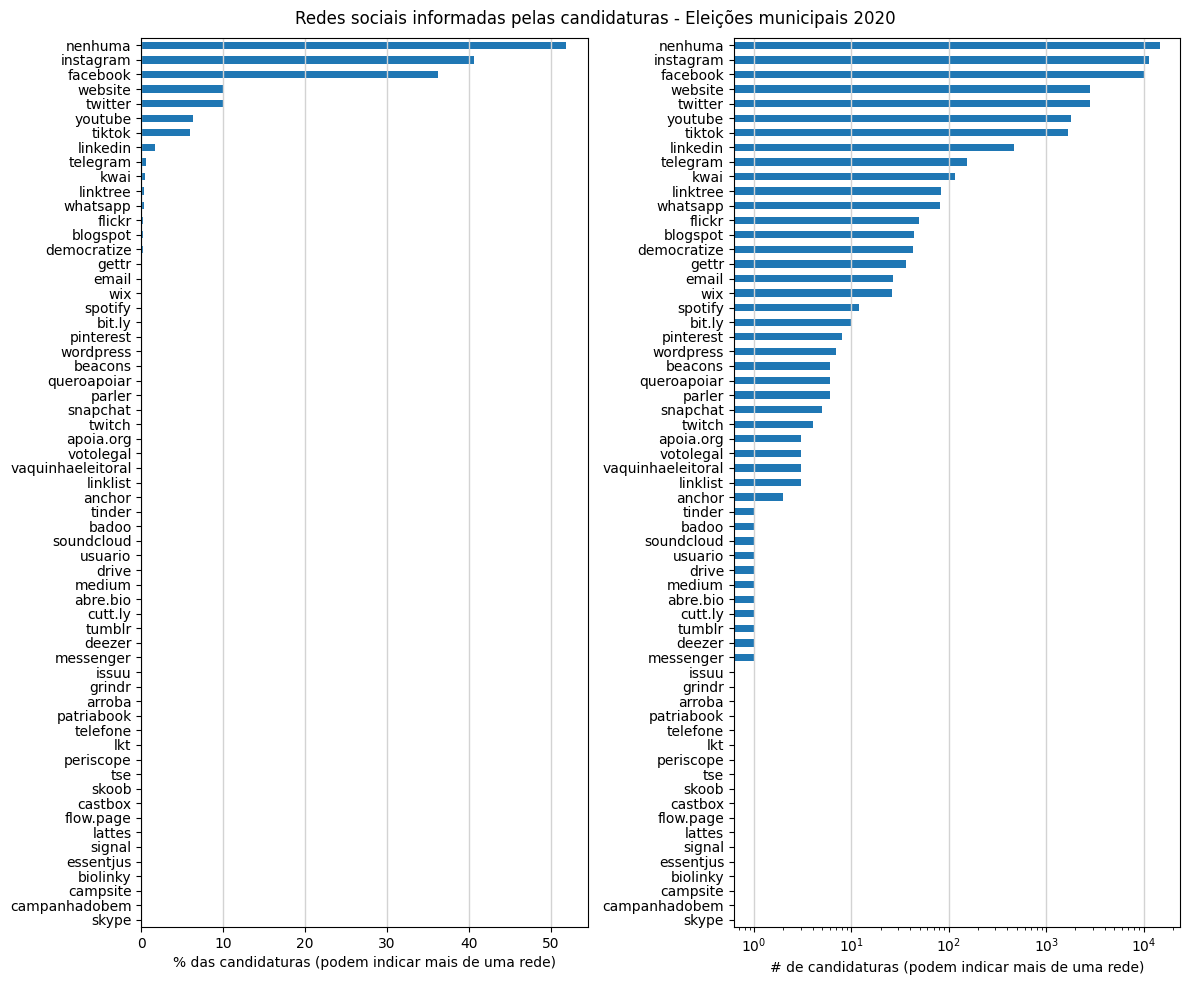

In [28]:
pl.figure(figsize=(12,10))
pl.suptitle('Redes sociais informadas pelas candidaturas - Eleições municipais 2020')

pl.subplot(1,2,1)
(use22_df[redes_cols].mean() * 100).sort_values().plot(kind='barh')
pl.grid(axis='x', color='lightgray', linewidth=1)
pl.xlabel('% das candidaturas (podem indicar mais de uma rede)')

pl.subplot(1,2,2)
use22_df[redes_cols].sum().sort_values().plot(kind='barh')
pl.grid(axis='x', color='lightgray', linewidth=1)
pl.xlabel('# de candidaturas (podem indicar mais de uma rede)')
pl.xscale('log')

pl.tight_layout()
# Para salvar o resultado, descomente a linha abaixo (ela fica comentada para evitar sobrescrever o arquivo por acidente):
#pl.savefig(Path('plots/redes_sociais_das_candidaturas_2020.png'))
pl.show()

## Dados de 2020

Vamos explorar os dados disponíveis no presente momento - os de 2020 - para nos prepararmos para a chegada dos dados de 2022.

### Carregando os dados

Fonte: <https://cdn.tse.jus.br/estatistica/sead/odsele/consulta_cand/rede_social_candidato_2020.zip>

In [30]:
# Carrega perfil dos candidatos:
cand_sel_cols = ['SQ_CANDIDATO', 'NM_CANDIDATO', 'SG_PARTIDO', 'SG_UF', 'SG_UE', 'NM_UE', 'DS_CARGO', 'NM_SOCIAL_CANDIDATO', 'NR_IDADE_DATA_POSSE', 'DS_GENERO', 'DS_GRAU_INSTRUCAO', 'DS_COR_RACA']

xz.sync_remote_zipped_files('https://nuvem.ceweb.br/s/2HGbHTrWmnLwqjr/download/consulta_cand_2020_BRASIL.zip', '../dados/limpos/tse/consulta_cand/', keep_zip_dir=False) 
cand20_df = pd.read_csv(Path('../dados/limpos/tse/consulta_cand/consulta_cand_2020_BRASIL.csv'), low_memory=False)
cand20_df = cand20_df[cand_sel_cols].drop_duplicates()
assert xd.iskeyQ(cand20_df[['SQ_CANDIDATO']])

# Carrega e junta número de eleitores:
if cand20_df['SG_UE'].dtype == np.dtype('int64'):
    ue_col = 'CD_MUNICIPIO'
else:
    ue_col = 'SG_UF'
xz.sync_remote_zipped_files('https://nuvem.ceweb.br/s/dq33a5KdTL3m6mn/download/perfil_eleitorado_2020.zip', '../dados/limpos/tse/perfil_eleitorado/', keep_zip_dir=False)
eleitores = load_n_eleitores_by_ue('../dados/limpos/tse/perfil_eleitorado/perfil_eleitorado_2020.csv', ue_col)
cand20_df = cand20_df.join(eleitores, on='SG_UE')
assert xd.iskeyQ(cand20_df[['SQ_CANDIDATO']])

xz.sync_remote_zipped_files('https://nuvem.ceweb.br/s/4SrtdWnNjmqDSzj/download/bem_candidato_2020_BRASIL.zip', '../dados/limpos/tse/bens_candidatos/', keep_zip_dir=False)
bens20_df = load_bem_build_features('../dados/limpos/tse/bens_candidatos/bem_candidato_2020_BRASIL.csv', index_cols=['SQ_CANDIDATO'])

cand20_df = cand20_df.join(bens20_df, on='SQ_CANDIDATO')
cand20_df['NUMERO_BENS'].fillna(0, inplace=True)
cand20_df['VALOR_TOTAL_BENS'].fillna(0, inplace=True)

Found a local file, skip download.
Found a local file, skip download.
Found a local file, skip download.


In [32]:
# Carrega dados das redes:
path = Path('../dados/brutos/tse/redes_sociais/rede_social_candidato_2020.csv')
xz.sync_remote_zipped_files('https://nuvem.ceweb.br/s/zbyiMRJa7w66j74/download/rede_social_candidato_2020.zip', str(path.parents[0]), keep_zip_dir=False) 
expected_cols   = ['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO', 'NM_TIPO_ELEICAO', 'CD_ELEICAO', 'DS_ELEICAO', 'SQ_CANDIDATO', 'NR_ORDEM', 'DS_URL']
expected_dtypes = [np.dtype('O'), np.dtype('O'), np.dtype('int64'), np.dtype('int64'), np.dtype('O'), np.dtype('int64'), np.dtype('O'), np.dtype('int64'), np.dtype('int64'), np.dtype('O')] 
redes20_df = load_tse_social_data(path, expected_cols, expected_dtypes)

# Classificando URLs:
dump = add_platform_onehot(redes20_df, redes_regex, website_regex, arroba_regex)

# Juntando dados:
#cand_redes20_df = join_cand_redes(cand20_df, redes20_df, cand_sel_cols)

Found a local file, skip download.


In [33]:
# Exporta dados:
#redes20_df.to_csv(Path('../dados/processados/redes_candidatos_2020.csv'), index=False)

#### Testes dos dados

In [34]:
# Exemplos de identificação geral:
check = redes20_df.iloc[:, 9:].sample(10).transpose()
check.loc[check.sum(axis=1) != 0].transpose()

,DS_URL,facebook,instagram
115526,https://www.facebook.com/eliza.virginia,1,0
125315,https://www.facebook.com/profile.php?id=100006...,1,0
277343,https://www.facebook.com/BrunoFlorianoGuaicara/,1,0
247378,facebook.com/eufrazio.debarros,1,0
129028,https://www.facebook.com/TaschimMateus,1,0
175149,https://www.instagram.com/gconrado2018?r=nametag,0,1
143336,https://www.facebook.com/edu290572,1,0
18288,Instagram: Lindama Gomes,0,1
62217,HTTPS://WWW.FACEBOOK.COM/ZELMO.COINETHE,1,0
228933,https://www.facebook.com/ika.bisognin.3,1,0


In [35]:
# Usuários sem rede identificada (e sem arroba):
check = redes20_df.loc[redes20_df['usuario'] == 1]
print(len(check))
xd.print_string_series(check['DS_URL'].sample(10))

11678
107215: CILMARA.BONFIM
120019: ARI LUIS JARCZEWSKI
308058: José Janeiro Sobrinho
186808: diegonasci
5846: ANTONIO BRITO
289911: Junior de Vitto
116400: aj_082.98
49362: NETA DO QUIRINO 
264573: CABO ANDERSON PROERD
273269: Professora Claudia Palmeira


In [36]:
# Testing regex improvement:
sel = redes20_df['DS_URL'].loc[regex_selector(redes20_df['DS_URL'], 'n[aã]o (?:tem|possui)|nenhum', case=False)].loc[regex_selector(redes20_df['DS_URL'], 'n[aã]o (?:tem|possui)', case=False, exists=False)].drop_duplicates()
print('#: {}'.format(len(sel)))
xd.print_string_series(sel)

#: 4
3830: Nenhum
82942: nenhum
230684: NENHUM
260576: NENHUMA


In [37]:
# Exemplos de URLs selecionadas:
category = 'arroba'
xd.print_string_series(redes20_df.loc[redes20_df[category] == 1, 'DS_URL'].sample(10))

91473: @anoticiabraunasmg
2211: @janinetenoriomurici
296274: @magrelaleo
226905: @paulo.heberle
45609: @lucienemota85
114984: @kleiton_carreiro
178080: @clebermjsilva
163591: @agacylopes
109234: @pablosobrinho12
164822: @jessiara_cardoso


In [38]:
# Identifying websites:
website_regex = r'ht{1,2}p{1,2}s?:/{0,3}(?:www\.)?(?:[\w\-]+\.)+[\w\-]{2,6}|www\.(?:[\w\-]+\.)+[\w\-]{2,6}|\.(?:com|org|net)$|\.(?:com|art)\.br'
series = redes20_df['DS_URL']
no_redes = series.loc[~regex_selector(series, '|'.join(redes_regex.values()), case=False)]
sel = no_redes.loc[regex_selector(series, r'ht{1,2}p{1,2}s?:/{0,3}(?:www\.)?(?:[\w\-]+\.)+[\w\-]{2,6}|www\.(?:[\w\-]+\.)+[\w\-]{2,6}|\.(?:com|org|net)$|\.(?:com|art)\.br', case=False)].loc[regex_selector(series,  r'ht{1,2}p{1,2}s?:/{0,3}(?:www\.)?(?:[\w\-]+\.)+[\w\-]{2,6}|www\.(?:[\w\-]+\.)+[\w\-]{2,6}', exists=False, case=False)].drop_duplicates()
print('#: {}'.format(len(sel)))
xd.print_string_series(sel.sample(100))

#: 728
72831: encurtador.com.br/lmntR
316530: luiscarlosferreira2030gmail.com
176956: mayconabrantes.com
284346: drtiagosierra.com.br
189942: paulosilvaedrnei.com.br
220518: Miguelcrizel.com.br
79749: alcemireprofessoradionir25.com.br
91912: blog.drcharlin.com.br
162917: josele.com.br
41699: valerianoabreu.com.br
305219: ronaldodaacademia.com.br
287502: claricefernandes17860.com.br
264080: vereadorrodrigomanga.com.br
97637: weltonoliva.com.br
226031: pozzobomprefeito45.com.br
154835: Blogdoronaldocesar.com.br
141418: site: vereadordan.com.br
276182: claudiofreitas.com.br
87294: wesleydejesus.com.br
263473: WWW.RAUL THAME.COM
225467: wwwluizhenriqueimoveis.com.br
45477: danielmendesaee.com.br
170175: Nicollecalheiros.com.br
212454: marcelosgarbossa.com.br
52965: simone55321.com.br
307310: vemcomoliveira.com.br
121739: marisalobo.com.br
295638: bwbrasil.com.br
307939: joaomiguelgasparim.com.br
287837: ronaldolacerda.com.br
206174: robertaleitao.com.br
28165: Site: professorarejanepinheir

In [39]:
# URLs com mais de uma categoria:
check = redes20_df.loc[redes20_df.iloc[:, 10:].sum(axis=1) > 1]
print(len(check))
xd.print_string_series(check['DS_URL'].sample(10))

1462
236455: INSTAGRAM: ronald.opaulino - facebook: ronaldo paulino
252619: instagram@carla.diolliver
238730: Vereador Reconhecido: bit.ly/VereadorReconhecido YouTube: 
105067: https://www.instagram.com/tati.para , https://www.facebook.com/tatiana.m.defreit
188041: Instagram.com/sb-amor@hotmail.com
28230: youtube: https://bit.ly/32kwTi8
245919: https://www.facebook.com/Elei%C3%A7%C3%B5es-2020-Lucimara-Vieira-103619628181396/?referrer=whatsapp
20375: no youtube: wagnerdamas.vereador2020@gmail.com
93556: (instagram) @renancouto.patriota, (facebook) Renan Couto 
32945: facebook e instagran


### Contagem de ocorrências

In [40]:
# Find out if a candidate uses a platform or not:
use20_df = platform_use_by_cand(cand20_df, redes20_df, redes_cols)

#### Uso geral

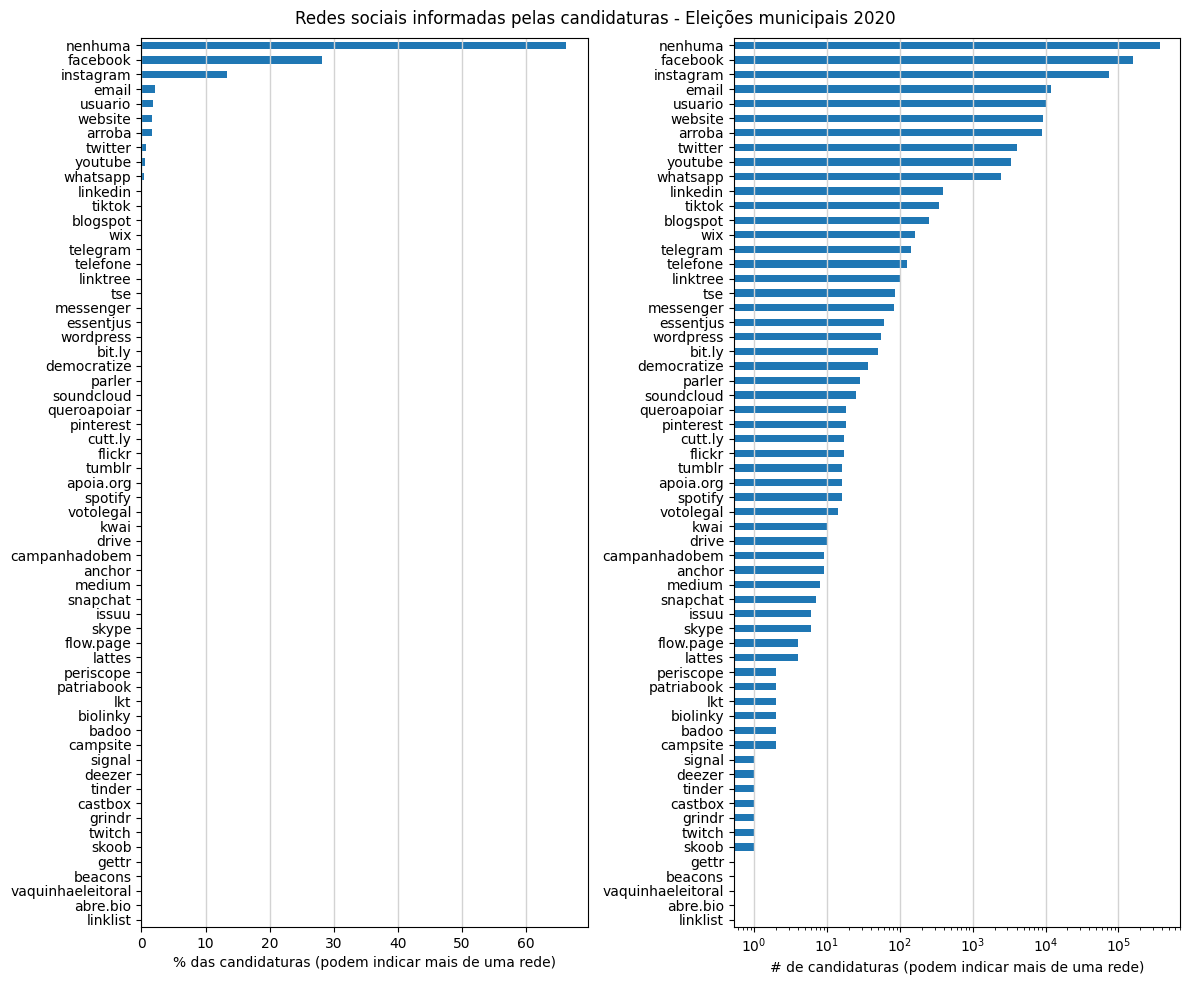

In [41]:
pl.figure(figsize=(12,10))
pl.suptitle('Redes sociais informadas pelas candidaturas - Eleições municipais 2020')

pl.subplot(1,2,1)
(use20_df[redes_cols].mean() * 100).sort_values().plot(kind='barh')
pl.grid(axis='x', color='lightgray', linewidth=1)
pl.xlabel('% das candidaturas (podem indicar mais de uma rede)')

pl.subplot(1,2,2)
use20_df[redes_cols].sum().sort_values().plot(kind='barh')
pl.grid(axis='x', color='lightgray', linewidth=1)
pl.xlabel('# de candidaturas (podem indicar mais de uma rede)')
pl.xscale('log')

pl.tight_layout()
# Para salvar o resultado, descomente a linha abaixo (ela fica comentada para evitar sobrescrever o arquivo por acidente):
#pl.savefig(Path('plots/redes_sociais_das_candidaturas_2020.png'))
pl.show()

#### Por bens dos candidatos

In [42]:
values = cand20_df['VALOR_TOTAL_BENS'].clip(lower=101, upper=1e7)
max_values = values.max()
min_values = values.min()
values_bins = np.logspace(np.floor(np.log10(min_values)), np.ceil(np.log10(max_values)), 20)
values_labels = ((values_bins[1:] + values_bins[:1]) / 2).astype(int)
values_digit = pd.cut(values, values_bins, labels=values_labels)

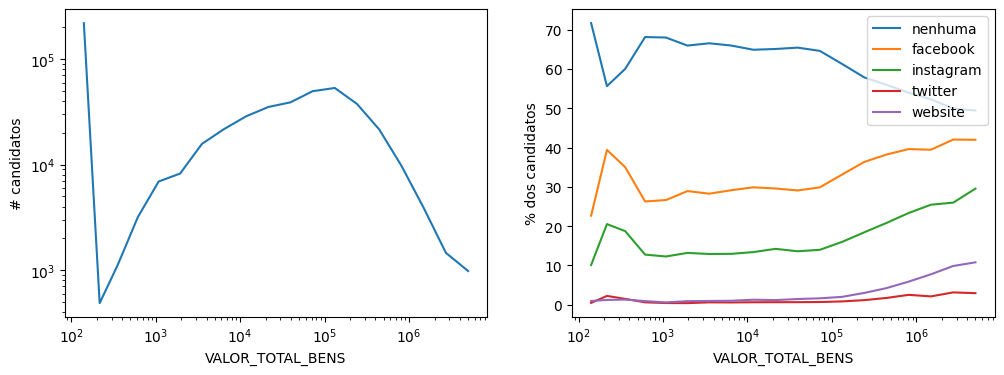

In [43]:
criterium = 'VALOR_TOTAL_BENS'

pl.figure(figsize=(12,4))

pl.subplot(1,2,1)
n_data = use20_df.groupby(values_digit).size().sort_index()
pl.plot(n_data.index, n_data)
pl.ylabel('# candidatos')
pl.yscale('log')
pl.xscale('log')
pl.xlabel(criterium)

use_by_group = use20_df.groupby(values_digit)[redes_cols].mean() * 100

pl.subplot(1,2,2)
sel_plats = ['nenhuma', 'facebook', 'instagram', 'twitter', 'website']
#sel_plats = ['twitter', 'youtube', 'website']
for plat in sel_plats:
    pl.plot(use_by_group.index, use_by_group[plat], label=plat)
pl.ylabel('% dos candidatos')
pl.xlabel(criterium)
pl.xscale('log')
pl.legend()
pl.show()

#### Por tamanho da unidade eleitoral

In [44]:
max_eleitores = use20_df['QT_ELEITORES_PERFIL'].max()
min_eleitores = use20_df['QT_ELEITORES_PERFIL'].min()
eleitores_bins = np.logspace(np.floor(np.log10(min_eleitores)), np.ceil(np.log10(max_eleitores)), 17)
#eleitores_bins = np.linspace(min_eleitores, max_eleitores, 20)
eleitores_labels = ((eleitores_bins[1:] + eleitores_bins[:1]) / 2).astype(int)
eleitores_digit = pd.cut(use20_df['QT_ELEITORES_PERFIL'], eleitores_bins, labels=eleitores_labels)

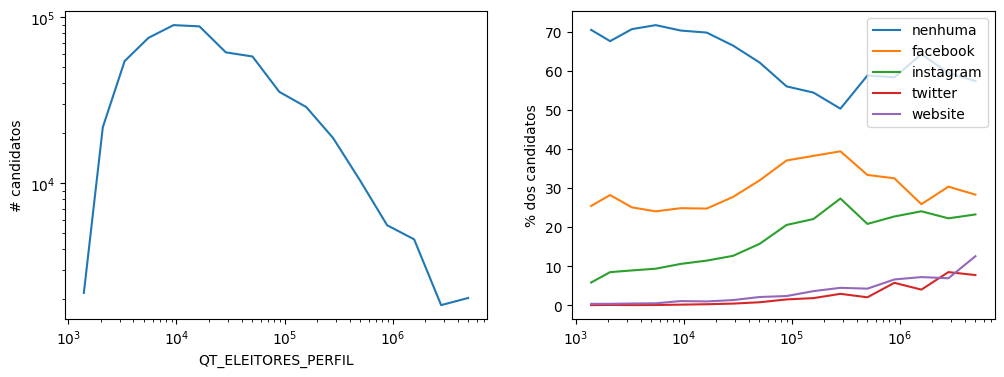

In [45]:
criterium = 'QT_ELEITORES_PERFIL'

pl.figure(figsize=(12,4))

pl.subplot(1,2,1)
n_data = use20_df.groupby(eleitores_digit).size().sort_index()
pl.plot(n_data.index, n_data)
pl.ylabel('# candidatos')
pl.yscale('log')
pl.xscale('log')
pl.xlabel(criterium)

use_by_group = use20_df.groupby(eleitores_digit)[redes_cols].mean() * 100

pl.subplot(1,2,2)
sel_plats = ['nenhuma', 'facebook', 'instagram', 'twitter', 'website']
#sel_plats = ['twitter', 'youtube', 'website']
for plat in sel_plats:
    pl.plot(use_by_group.index, use_by_group[plat], label=plat)
pl.ylabel('% dos candidatos')
pl.xscale('log')
pl.legend()
pl.show()

#### Por idade

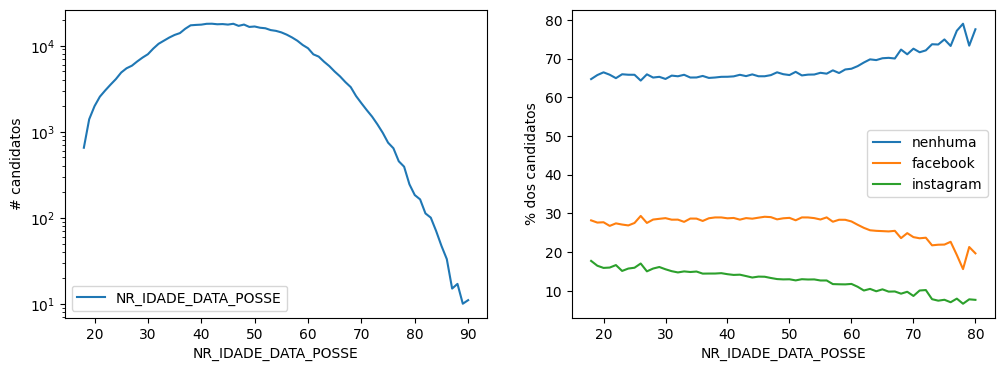

In [46]:
criterium = 'NR_IDADE_DATA_POSSE'

pl.figure(figsize=(12,4))

pl.subplot(1,2,1)
use20_df[criterium].value_counts().sort_index().loc[18:90].plot()
pl.ylabel('# candidatos')
pl.yscale('log')
pl.xlabel(criterium)
pl.legend()

use_by_group = use20_df.groupby(criterium)[redes_cols].mean() * 100

pl.subplot(1,2,2)
use_by_group.loc[18:80, 'nenhuma'].plot()
use_by_group.loc[18:80, 'facebook'].plot()
use_by_group.loc[18:80, 'instagram'].plot()
#use_by_group.loc[18:80, 'twitter'].plot()
#use_by_group.loc[18:80, 'website'].plot()
pl.ylabel('% dos candidatos')
pl.legend()
pl.show()

#### Por cargo

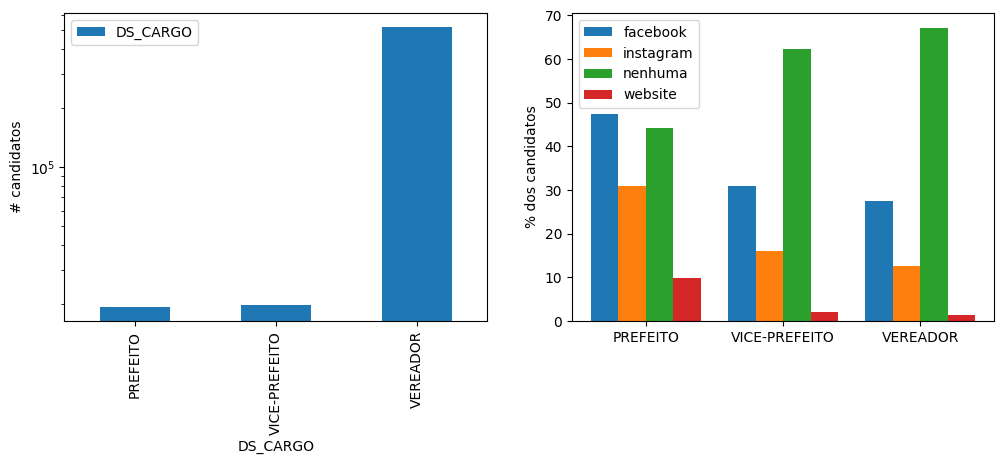

In [47]:
plot_platform_use_by_group(use20_df, 'DS_CARGO', ['PREFEITO', 'VICE-PREFEITO', 'VEREADOR'])

#### Por escolaridade

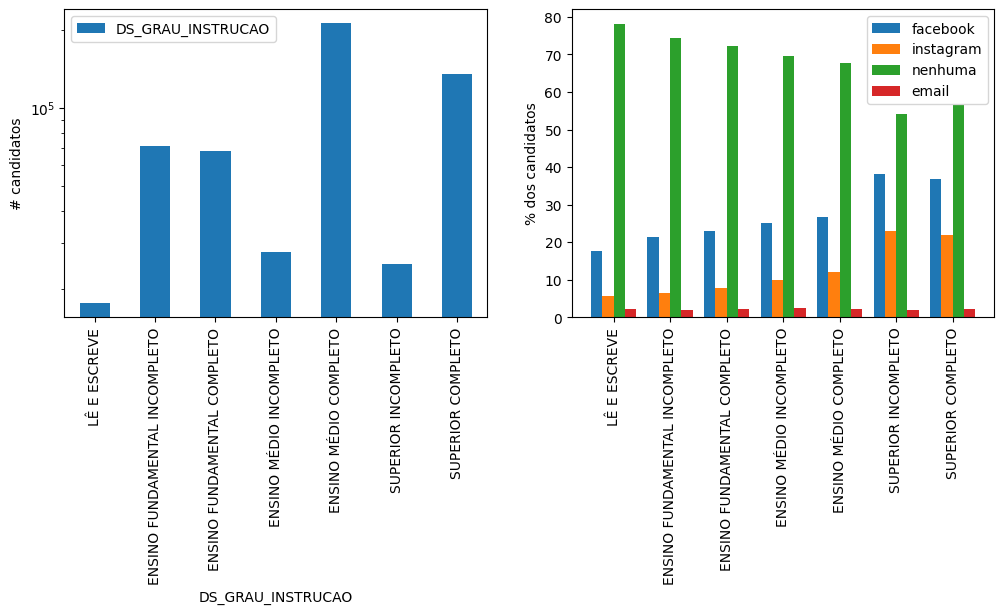

In [48]:
cats = ['LÊ E ESCREVE', 'ENSINO FUNDAMENTAL INCOMPLETO', 'ENSINO FUNDAMENTAL COMPLETO', 'ENSINO MÉDIO INCOMPLETO', 'ENSINO MÉDIO COMPLETO', 'SUPERIOR INCOMPLETO', 'SUPERIOR COMPLETO']
plot_platform_use_by_group(use20_df, 'DS_GRAU_INSTRUCAO', cats, rotate=True)

#### Por partido

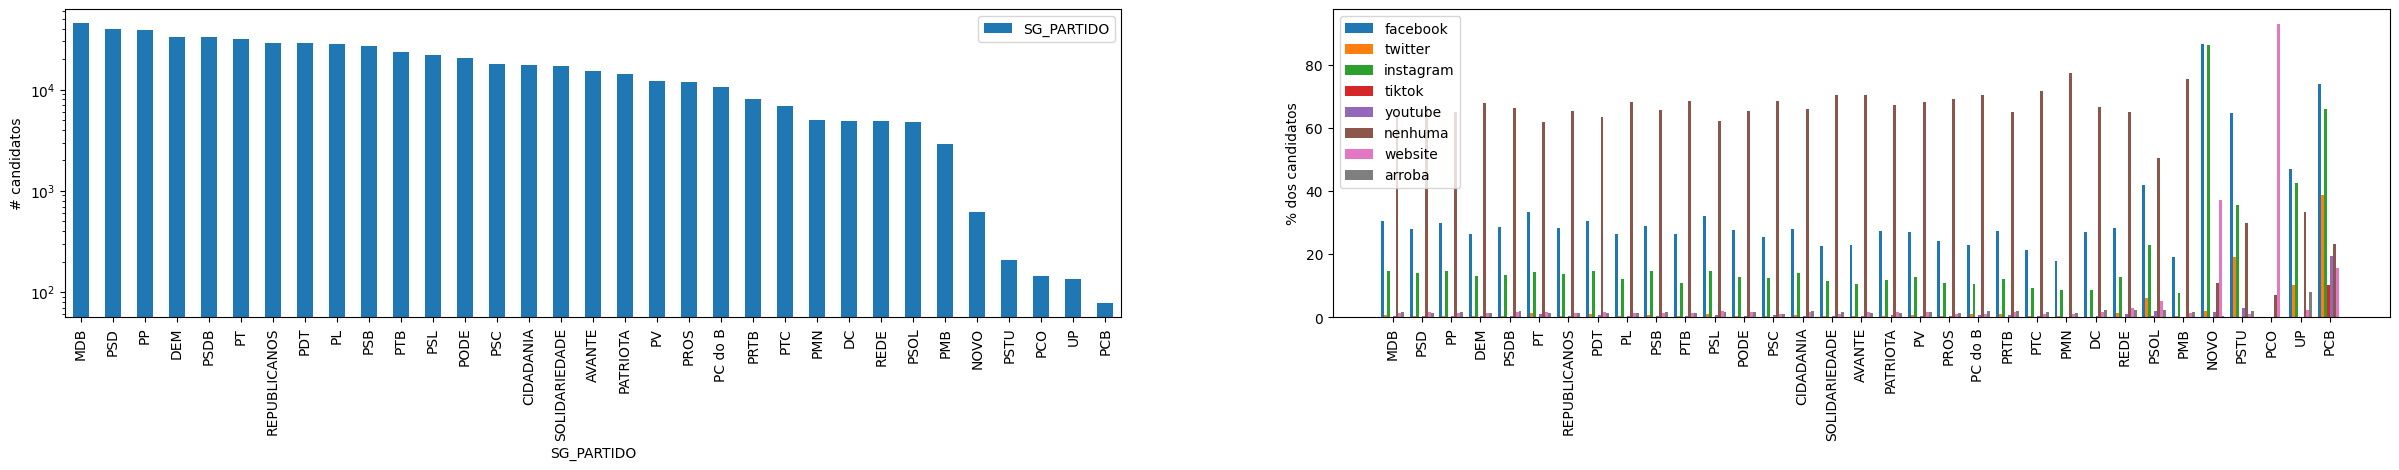

In [49]:
cats = ['PRTB', 'PSL', 'NOVO', 'PL', 'PMB', 'REPUBLICANOS', 'DC', 'DEM', 'PATRIOTA', 'PMN', 'PP', 'PSC', 'PTB', 'PTC', 'AVANTE', 
        'PSD', 'PSDB', 'MDB', 'PODE', 'PROS', 'SOLIDARIEDADE', 'CIDADANIA', 'PV', 'PSB', 'REDE', 'PDT', 'PC do B', 'PSOL', 
        'PT', 'PCB', 'PCO', 'PSTU', 'UP']
cats = use20_df['SG_PARTIDO'].value_counts().index
plot_platform_use_by_group(use20_df, 'SG_PARTIDO', cats, fig_width=30, rotate=True)

#### Por estado

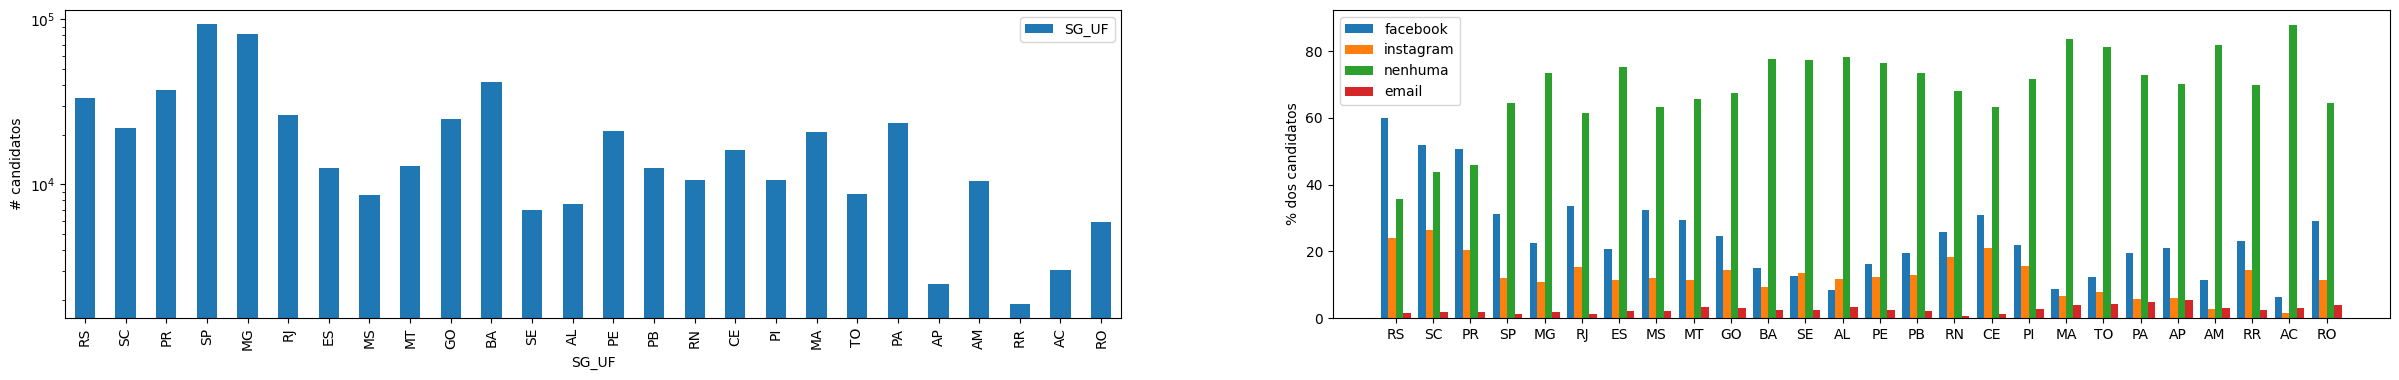

In [50]:
cats = ['RS', 'SC', 'PR', 'SP', 'MG', 'RJ', 'ES', 'MS', 'MT', 'GO', 'BA', 'SE', 'AL', 'PE', 'PB', 'RN', 'CE', 'PI', 'MA', 'TO', 'PA', 'AP', 'AM', 'RR', 'AC', 'RO']
plot_platform_use_by_group(use20_df, 'SG_UF', cats, fig_width=30)

#### Por gênero

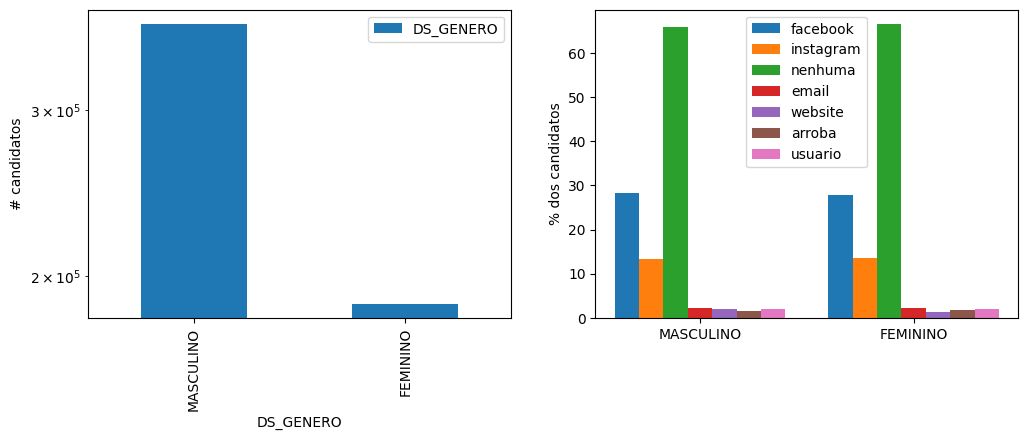

In [51]:
#cats = ['LÊ E ESCREVE', 'ENSINO FUNDAMENTAL INCOMPLETO', 'ENSINO FUNDAMENTAL COMPLETO', 'ENSINO MÉDIO INCOMPLETO', 'ENSINO MÉDIO COMPLETO', 'SUPERIOR INCOMPLETO', 'SUPERIOR COMPLETO']
plot_platform_use_by_group(use20_df, 'DS_GENERO', min_frac=1)

#### Por raça

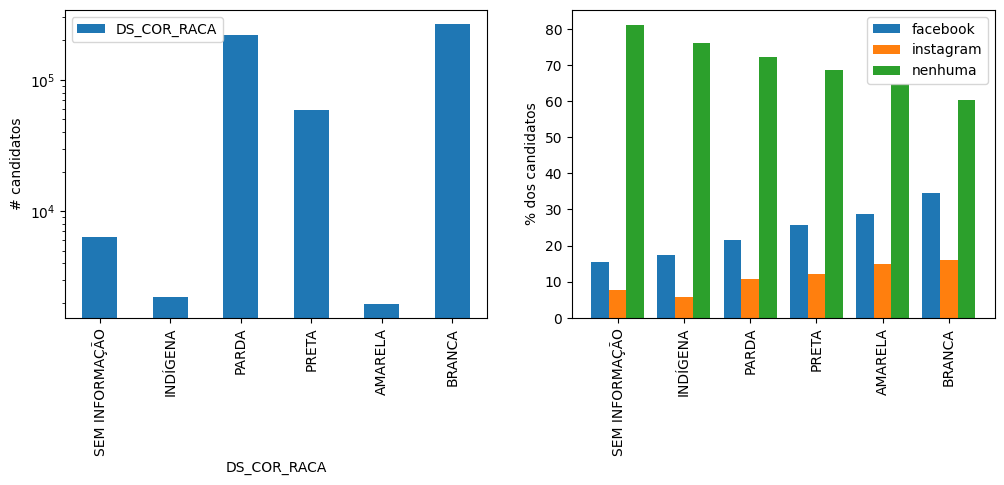

In [52]:
plot_platform_use_by_group(use20_df, 'DS_COR_RACA', ['SEM INFORMAÇÃO', 'INDÍGENA', 'PARDA', 'PRETA', 'AMARELA', 'BRANCA'], rotate=True)

### Contagem de ocorrências nos URLs (ngram)

In [53]:
from sklearn.feature_extraction.text import CountVectorizer

In [54]:
# Separa as palavras das URLs:
cleaned_series = redes20_df['DS_URL'].str.lower().apply(lambda s: xt.remove_punctuation(s, whitespace=True)).str.replace('\d+', '', regex=True)

In [55]:
# Cria lista de nomes dos candidatos:
names_vec = CountVectorizer()
name_counts = np.array(names_vec.fit_transform(cand20_df['NM_CANDIDATO'].dropna().str.replace('\d+', ' ', regex=True)).sum(axis=0))[0]
name_series = pd.Series(name_counts, index=names_vec.get_feature_names_out()).sort_values(ascending=False)

In [56]:
# Remove palavras irrelevantes na identificação das URLs:
stopwords = ['http', 'https', 'www', 'com', 'br', 'da', 'de', 'do', 'php', 'id', 'pt', 'hl', 'top', 'search', 'ref', 'org', 'nametag', 
             'profile', 'igshid', 'web', 'content', 'as', 'ao', 'utm', 'view', 'people', 'dos', 'user', 'pg', 'fbid', 'about', 'in', 
             'filter', 'htpp', 'htpps', 'source', 'fbclid', 'login', 'posts', 'admin'] + list(name_series.loc[name_series > 100].index)

# Conta termos das URLs:
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10, stop_words=stopwords)
word_counts = np.array(vectorizer.fit_transform(cleaned_series).sum(axis=0))[0]
counts_series = pd.Series(word_counts, index=vectorizer.get_feature_names_out()).sort_values(ascending=False)

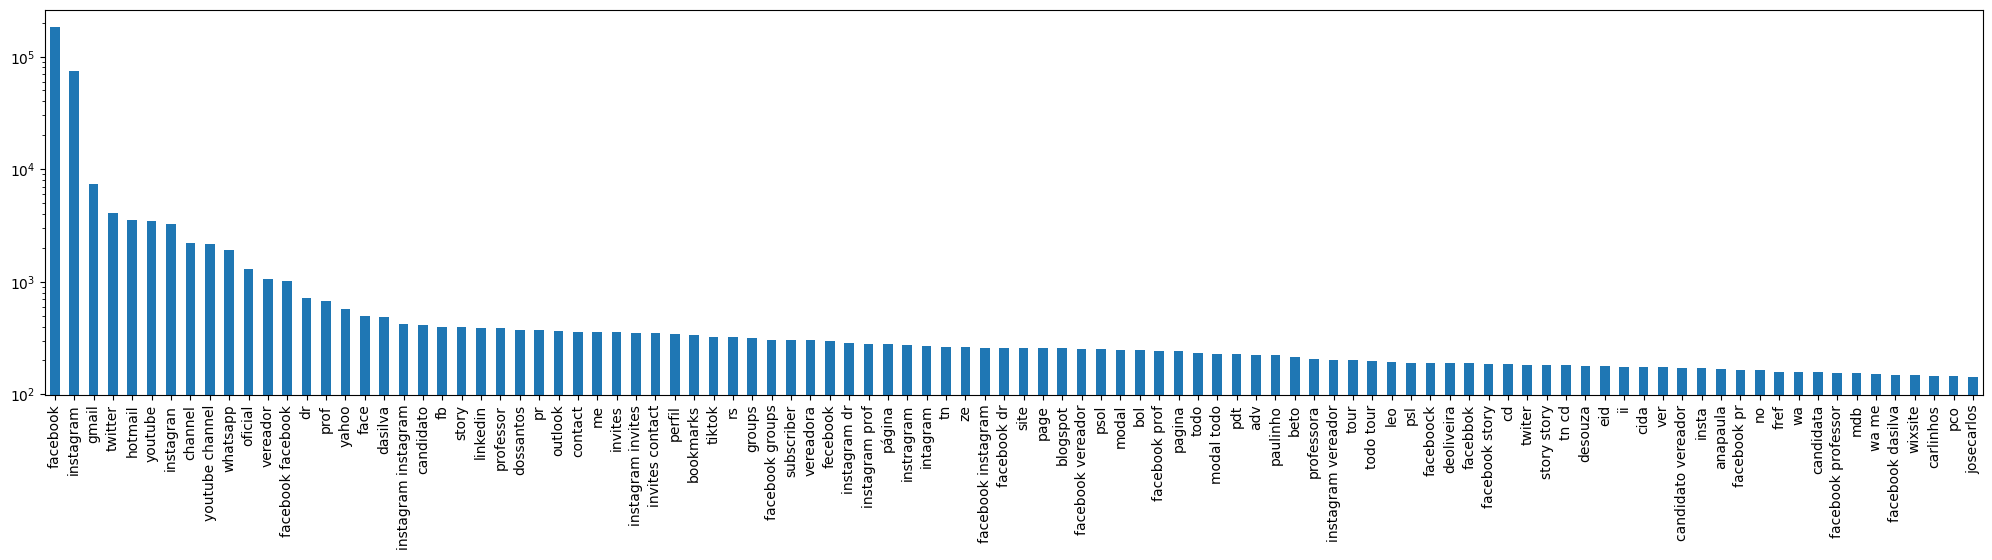

In [57]:
pl.figure(figsize=(25,5))
counts_series.iloc[:100].plot(kind='bar')
pl.yscale('log')
pl.show()

### Exploração

**Conclusões**

* Cada linha corresponde a uma rede de um candidato. 
* A coluna NR_ORDEM contabiliza as redes de cada candidato
* A maioria dos candidatos das eleições municipais de 2020 não declarou nenhuma rede social.

In [58]:
# Cara dos dados:
redes20_df.head()

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,CD_ELEICAO,DS_ELEICAO,SQ_CANDIDATO,NR_ORDEM,DS_URL,...,abre.bio,gettr,beacons,vaquinhaeleitoral,linklist,nenhuma,email,website,arroba,usuario
0,14/09/2021,13:41:29,2020,2,ELEIÇÃO ORDINÁRIA,426,ELEIÇÕES MUNICIPAIS 2020,10000644871,1,www.facebook.com/celio.rocha.9041,...,0,0,0,0,0,0,0,0,0,0
1,14/09/2021,13:41:29,2020,2,ELEIÇÃO ORDINÁRIA,426,ELEIÇÕES MUNICIPAIS 2020,10000644918,1,www.facebook.com/profile.jhp?id=100007267118190,...,0,0,0,0,0,0,0,0,0,0
2,14/09/2021,13:41:29,2020,2,ELEIÇÃO ORDINÁRIA,426,ELEIÇÕES MUNICIPAIS 2020,10000644932,1,www.facebook.com/maria.fia.7777,...,0,0,0,0,0,0,0,0,0,0
3,14/09/2021,13:41:29,2020,2,ELEIÇÃO ORDINÁRIA,426,ELEIÇÕES MUNICIPAIS 2020,10000701042,1,https://www.facebook.com/ismael.muniz.5,...,0,0,0,0,0,0,0,0,0,0
4,14/09/2021,13:41:29,2020,2,ELEIÇÃO ORDINÁRIA,426,ELEIÇÕES MUNICIPAIS 2020,10000701209,1,https://www.facebook.com/djblackjunior41/,...,0,0,0,0,0,0,0,0,0,0


#### Identificação de linha

In [59]:
xd.iskeyQ(redes20_df[['SQ_CANDIDATO', 'NR_ORDEM']])

True

#### Significado do NR_ORDEM e estrutura dos dados

In [60]:
cand_stats_df = pd.DataFrame()
cand_stats_df['max_NR_ORDEM'] = redes20_df.groupby('SQ_CANDIDATO')['NR_ORDEM'].max().sort_values(ascending=False)
cand_stats_df['n_redes'] = redes20_df['SQ_CANDIDATO'].value_counts()

# NR_ORDEM numera as redes sociais associadas a um mesmo candidato:
assert len(xe.checkMissing(cand_stats_df, return_df=True)) == 0
assert (cand_stats_df['max_NR_ORDEM'] == cand_stats_df['n_redes']).all()

In [61]:
# Caso com muitas redes:
maior_max_nr_ordem_df = redes20_df.loc[redes20_df['SQ_CANDIDATO'].isin(cand_stats_df.index[0:1])]
xd.print_string_series(maior_max_nr_ordem_df['DS_URL'])

121701: https://www.facebook.com/romulo.quenehen.9
121702: https://www.instagram.com/romulo.quenehen/
121703: https://www.facebook.com/romuloquenehenadvogado/
121704: https://www.facebook.com/cidadania.umbara.5
121705: https://www.facebook.com/bairrofazendinha
121706: https://www.facebook.com/cidadania.bairronovo.92
121707: https://www.facebook.com/bairrocampinadosiqueira
121708: https://www.facebook.com/bairrobutiatuvinha
121709: https://www.facebook.com/curitibaportao
121710: https://www.facebook.com/bairrosaobrazcuritiba
121711: https://www.facebook.com/bairrobacacheri
121712: https://www.facebook.com/bairronovomundo
121713: https://www.facebook.com/bairroorleans
121714: https://www.facebook.com/curitibaaguaverde
121715: https://www.facebook.com/gazeta.doboqueirao.9
121716: https://www.facebook.com/osternacksitiocercado
121717: https://www.facebook.com/curitibacapaoraso
121718: https://www.facebook.com/cidadania.jardimgabineto.7
121719: https://www.facebook.com/cidadaniasabara.cic.3

### Estatísticas

#### Identificação das redes sociais

In [62]:
redes20_df.loc[redes20_df['DS_URL'].str.strip() != redes20_df['DS_URL']]

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,CD_ELEICAO,DS_ELEICAO,SQ_CANDIDATO,NR_ORDEM,DS_URL,...,abre.bio,gettr,beacons,vaquinhaeleitoral,linklist,nenhuma,email,website,arroba,usuario
309,14/09/2021,13:41:29,2020,2,ELEIÇÃO ORDINÁRIA,426,ELEIÇÕES MUNICIPAIS 2020,10001068838,1,https://www.facebook.com/jamis.queiroz,...,0,0,0,0,0,0,0,0,0,0
537,14/09/2021,13:41:29,2020,2,ELEIÇÃO ORDINÁRIA,426,ELEIÇÕES MUNICIPAIS 2020,20000688576,1,FACEBOOK JAILSON DA LAGOA,...,0,0,0,0,0,0,0,0,0,0
565,14/09/2021,13:41:29,2020,2,ELEIÇÃO ORDINÁRIA,426,ELEIÇÕES MUNICIPAIS 2020,20000698809,1,Instagram: @rogerio_miliano,...,0,0,0,0,0,0,0,0,0,0
711,14/09/2021,13:41:29,2020,2,ELEIÇÃO ORDINÁRIA,426,ELEIÇÕES MUNICIPAIS 2020,20000699996,1,@vaniacoopvila,...,0,0,0,0,0,0,0,0,1,0
1331,14/09/2021,13:41:29,2020,2,ELEIÇÃO ORDINÁRIA,426,ELEIÇÕES MUNICIPAIS 2020,20000817387,1,Facebook:https//www.com/Valmir Mauro,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316441,14/09/2021,13:41:29,2020,2,ELEIÇÃO ORDINÁRIA,426,ELEIÇÕES MUNICIPAIS 2020,270001257946,2,Luzia Americana Gama de Lima,...,0,0,0,0,0,0,0,0,0,1
316535,14/09/2021,13:41:29,2020,2,ELEIÇÃO ORDINÁRIA,445,ELEIÇÕES MUNICIPAIS 2020 - AP,30000657962,2,facebook.com/gilson.torres.92,...,0,0,0,0,0,0,0,0,0,0
316882,14/09/2021,13:41:29,2020,1,ELEIÇÃO SUPLEMENTAR,468,NOVA ELEIÇÃO PETROLÂNDIA,240001368947,1,https://www.facebook.com/edsoneamarildo19/,...,0,0,0,0,0,0,0,0,0,0
317069,14/09/2021,13:41:29,2020,1,ELEIÇÃO SUPLEMENTAR,525,ELEIÇÃO SUPLEMENTAR DE ANGATUBA,250001397528,1,https://instagram.com/julianovolpii?igshid=1ks...,...,0,0,0,0,0,0,0,0,0,0


In [63]:
regex = '[\w\-\.]+@(?:[\w-]+\.)+[\w-]{2,4}$'
yes  = True
selector = regex_selector(redes20_df['DS_URL'], regex, yes, verbose=True)
xd.print_string_series(redes20_df.loc[selector, 'DS_URL'].sample(10))

'[\w\-\.]+@(?:[\w-]+\.)+[\w-]{2,4}$'
104900: ing.eleicao2020@gmail.com
157361: rca109@hotmail.com
265802: comitejonathancoelho@bol.com.br
60231: marcusm.macedo@hotmail.com
156106: DANIELPONCELL@GMAIL.COM
18464: marcosrita@msn.com
72920: jsmnilsinho@hotmail.com
48665: cdn.central@hotmail.com
156113: milkael.italo2014@gmail.com
265808: comitejonathancoelho@bol.com.br


In [64]:
regex = 'www'
yes   = False
selector = regex_selector(redes20_df['DS_URL'], regex, yes, verbose=True)
xd.print_string_series(redes20_df.loc[selector, 'DS_URL'].sample(10))

Not 'www'
135368: https://instagram.com/tiagobohnbogo?igshid=17tg8ce9hqcnf
286587: @jeansilva
113842: FACEBOOK ADEILTON MEIRA CHEF
13955: gillcimar_amorim06
314801: coradoaldo - instagram
60994: WWW.FACEBOOK.COM/MARIAAPARECIDA.PURCINELLI
288907: http://abelardinho.com.br/
112572: FACEBOOK: ARTEMIO SOUTO
157323: cidadaniacamaragibe232020@gmail.com
184310: https://instagram.com/fernandopintorn


In [65]:
regex = '(?:http|www|.+@.+\..+)'
yes   = False
selector  = regex_selector(redes20_df['DS_URL'], regex, yes, verbose=True, case=False)
selection = redes20_df.loc[selector, 'DS_URL']
print('#: {}   %: {:.2f}'.format(len(selection), len(selection) / len(redes20_df) * 100))
xd.print_string_series(selection.sample(10))

Not '(?:http|www|.+@.+\..+)' (any case)
#: 72541   %: 22.88
260859: facebook renatospirlandelli
298201: Face:  Emerson de Siqueira
31507: facebook.com/wescley.cazassi.3
291356: FACEBOOK ALESSANDROJDIAS
199394: geremias_mirin
151092: Roseli Machado
30682: instragran@emiliodeoliveirasilva
296858: facebook.com/ andrezinho theo
57862: INSTAGRAN: SERGIO_TADASHI_
271789: CLEBER.ZANIM


#### Frequência do uso de redes entre os candidatos

In [66]:
# Seleciona todos os candidatos uma só vez:
cand20_selcols_df = cand20_df[cand_sel_cols].drop_duplicates()
assert xd.iskeyQ(cand20_selcols_df['SQ_CANDIDATO'])

In [67]:
# Contabiliza redes:
count_redes_df = cand20_selcols_df.join(cand_stats_df['n_redes'], on='SQ_CANDIDATO')
count_redes_df['n_redes'].fillna(0, inplace=True)
count_redes_df['n_redes'] = count_redes_df['n_redes'].astype(int)

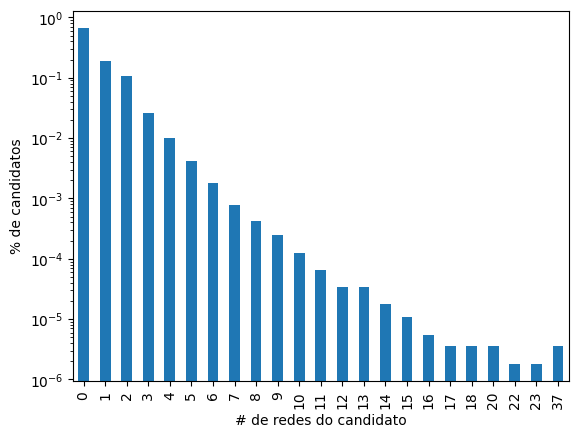

In [68]:
# Probabilidade de um candidato ter um dado número de redes cai exponencialmente:
(count_redes_df['n_redes'].value_counts() / len(count_redes_df)).sort_index().plot(kind='bar')
pl.yscale('log')
pl.ylabel('% de candidatos')
pl.xlabel('# de redes do candidato')
pl.show()

# Diferenças entre arquivos consulta_cand 2020 e 2022

In [69]:
import pandas as pd

import src.xavy.tse as tse
import src.xavy.explore as xe

## De cabeçalho

In [70]:
h20 = '"DT_GERACAO","HH_GERACAO","ANO_ELEICAO","CD_TIPO_ELEICAO","NM_TIPO_ELEICAO","NR_TURNO","CD_ELEICAO","DS_ELEICAO","DT_ELEICAO","TP_ABRANGENCIA","SG_UF","SG_UE","NM_UE","CD_CARGO","DS_CARGO","SQ_CANDIDATO","NR_CANDIDATO","NM_CANDIDATO","NM_URNA_CANDIDATO","NM_SOCIAL_CANDIDATO","NR_CPF_CANDIDATO","NM_EMAIL","CD_SITUACAO_CANDIDATURA","DS_SITUACAO_CANDIDATURA","CD_DETALHE_SITUACAO_CAND","DS_DETALHE_SITUACAO_CAND","TP_AGREMIACAO","NR_PARTIDO","SG_PARTIDO","NM_PARTIDO","SQ_COLIGACAO","NM_COLIGACAO","DS_COMPOSICAO_COLIGACAO","CD_NACIONALIDADE","DS_NACIONALIDADE","SG_UF_NASCIMENTO","CD_MUNICIPIO_NASCIMENTO","NM_MUNICIPIO_NASCIMENTO","DT_NASCIMENTO","NR_IDADE_DATA_POSSE","NR_TITULO_ELEITORAL_CANDIDATO","CD_GENERO","DS_GENERO","CD_GRAU_INSTRUCAO","DS_GRAU_INSTRUCAO","CD_ESTADO_CIVIL","DS_ESTADO_CIVIL","CD_COR_RACA","DS_COR_RACA","CD_OCUPACAO","DS_OCUPACAO","VR_DESPESA_MAX_CAMPANHA","CD_SIT_TOT_TURNO","DS_SIT_TOT_TURNO","ST_REELEICAO","ST_DECLARAR_BENS","NR_PROTOCOLO_CANDIDATURA","NR_PROCESSO","CD_SITUACAO_CANDIDATO_PLEITO","DS_SITUACAO_CANDIDATO_PLEITO","CD_SITUACAO_CANDIDATO_URNA","DS_SITUACAO_CANDIDATO_URNA","ST_CANDIDATO_INSERIDO_URNA","IDADE_DATA_ELEICAO","SG_LEGENDA"'
h22 = '"DT_GERACAO";"HH_GERACAO";"ANO_ELEICAO";"CD_TIPO_ELEICAO";"NM_TIPO_ELEICAO";"NR_TURNO";"CD_ELEICAO";"DS_ELEICAO";"DT_ELEICAO";"TP_ABRANGENCIA";"SG_UF";"SG_UE";"NM_UE";"CD_CARGO";"DS_CARGO";"SQ_CANDIDATO";"NR_CANDIDATO";"NM_CANDIDATO";"NM_URNA_CANDIDATO";"NM_SOCIAL_CANDIDATO";"NR_CPF_CANDIDATO";"NM_EMAIL";"CD_SITUACAO_CANDIDATURA";"DS_SITUACAO_CANDIDATURA";"CD_DETALHE_SITUACAO_CAND";"DS_DETALHE_SITUACAO_CAND";"TP_AGREMIACAO";"NR_PARTIDO";"SG_PARTIDO";"NM_PARTIDO";"NR_FEDERACAO";"NM_FEDERACAO";"SG_FEDERACAO";"DS_COMPOSICAO_FEDERACAO";"SQ_COLIGACAO";"NM_COLIGACAO";"DS_COMPOSICAO_COLIGACAO";"CD_NACIONALIDADE";"DS_NACIONALIDADE";"SG_UF_NASCIMENTO";"CD_MUNICIPIO_NASCIMENTO";"NM_MUNICIPIO_NASCIMENTO";"DT_NASCIMENTO";"NR_IDADE_DATA_POSSE";"NR_TITULO_ELEITORAL_CANDIDATO";"CD_GENERO";"DS_GENERO";"CD_GRAU_INSTRUCAO";"DS_GRAU_INSTRUCAO";"CD_ESTADO_CIVIL";"DS_ESTADO_CIVIL";"CD_COR_RACA";"DS_COR_RACA";"CD_OCUPACAO";"DS_OCUPACAO";"VR_DESPESA_MAX_CAMPANHA";"CD_SIT_TOT_TURNO";"DS_SIT_TOT_TURNO";"ST_REELEICAO";"ST_DECLARAR_BENS";"NR_PROTOCOLO_CANDIDATURA";"NR_PROCESSO";"CD_SITUACAO_CANDIDATO_PLEITO";"DS_SITUACAO_CANDIDATO_PLEITO";"CD_SITUACAO_CANDIDATO_URNA";"DS_SITUACAO_CANDIDATO_URNA";"ST_CANDIDATO_INSERIDO_URNA";"NM_TIPO_DESTINACAO_VOTOS";"CD_SITUACAO_CANDIDATO_TOT";"DS_SITUACAO_CANDIDATO_TOT";"ST_PREST_CONTAS"'

In [71]:
c20 = set(h20.replace('"', '').split(','))
c22 = set(h22.replace('"', '').split(';'))

In [72]:
# Colunas que sumiram:
c20 - c22

{'IDADE_DATA_ELEICAO', 'SG_LEGENDA'}

In [73]:
# Colunas novas:
new_cols = c22 - c20
new_cols

{'CD_SITUACAO_CANDIDATO_TOT',
 'DS_COMPOSICAO_FEDERACAO',
 'DS_SITUACAO_CANDIDATO_TOT',
 'NM_FEDERACAO',
 'NM_TIPO_DESTINACAO_VOTOS',
 'NR_FEDERACAO',
 'SG_FEDERACAO',
 'ST_PREST_CONTAS'}

## De conteúdo

In [74]:
cand22_df = tse.load_tse_raw_data('/home/hxavier/ceweb/dados/brutos/tse/consulta_cand_2022/consulta_cand_2022_BRASIL.csv')

In [75]:
xe.mapUnique(cand22_df[new_cols])


NM_TIPO_DESTINACAO_VOTOS: 1 unique values.
#NULO#

ST_PREST_CONTAS: 1 unique values.
N

NM_FEDERACAO: 4 unique values.
#NULO#,  Federação Brasil da Esperança - FE BRASIL,  Federação PSDB Cidadania,  Federação PSOL REDE

NR_FEDERACAO: 4 unique values.
-1,  1,  2,  3

CD_SITUACAO_CANDIDATO_TOT: 1 unique values.
-1

DS_COMPOSICAO_FEDERACAO: 4 unique values.
#NULO#,  CIDADANIA / PSDB,  PT / PV / PC do B,  REDE / PSOL

SG_FEDERACAO: 4 unique values.
#NULO#,  PSDB/CIDADANIA,  PSOL/REDE,  PT/PC do B/PV

DS_SITUACAO_CANDIDATO_TOT: 1 unique values.
#NULO#


/tmp/ipykernel_3325/1759366206.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xe.mapUnique(cand22_df[new_cols])


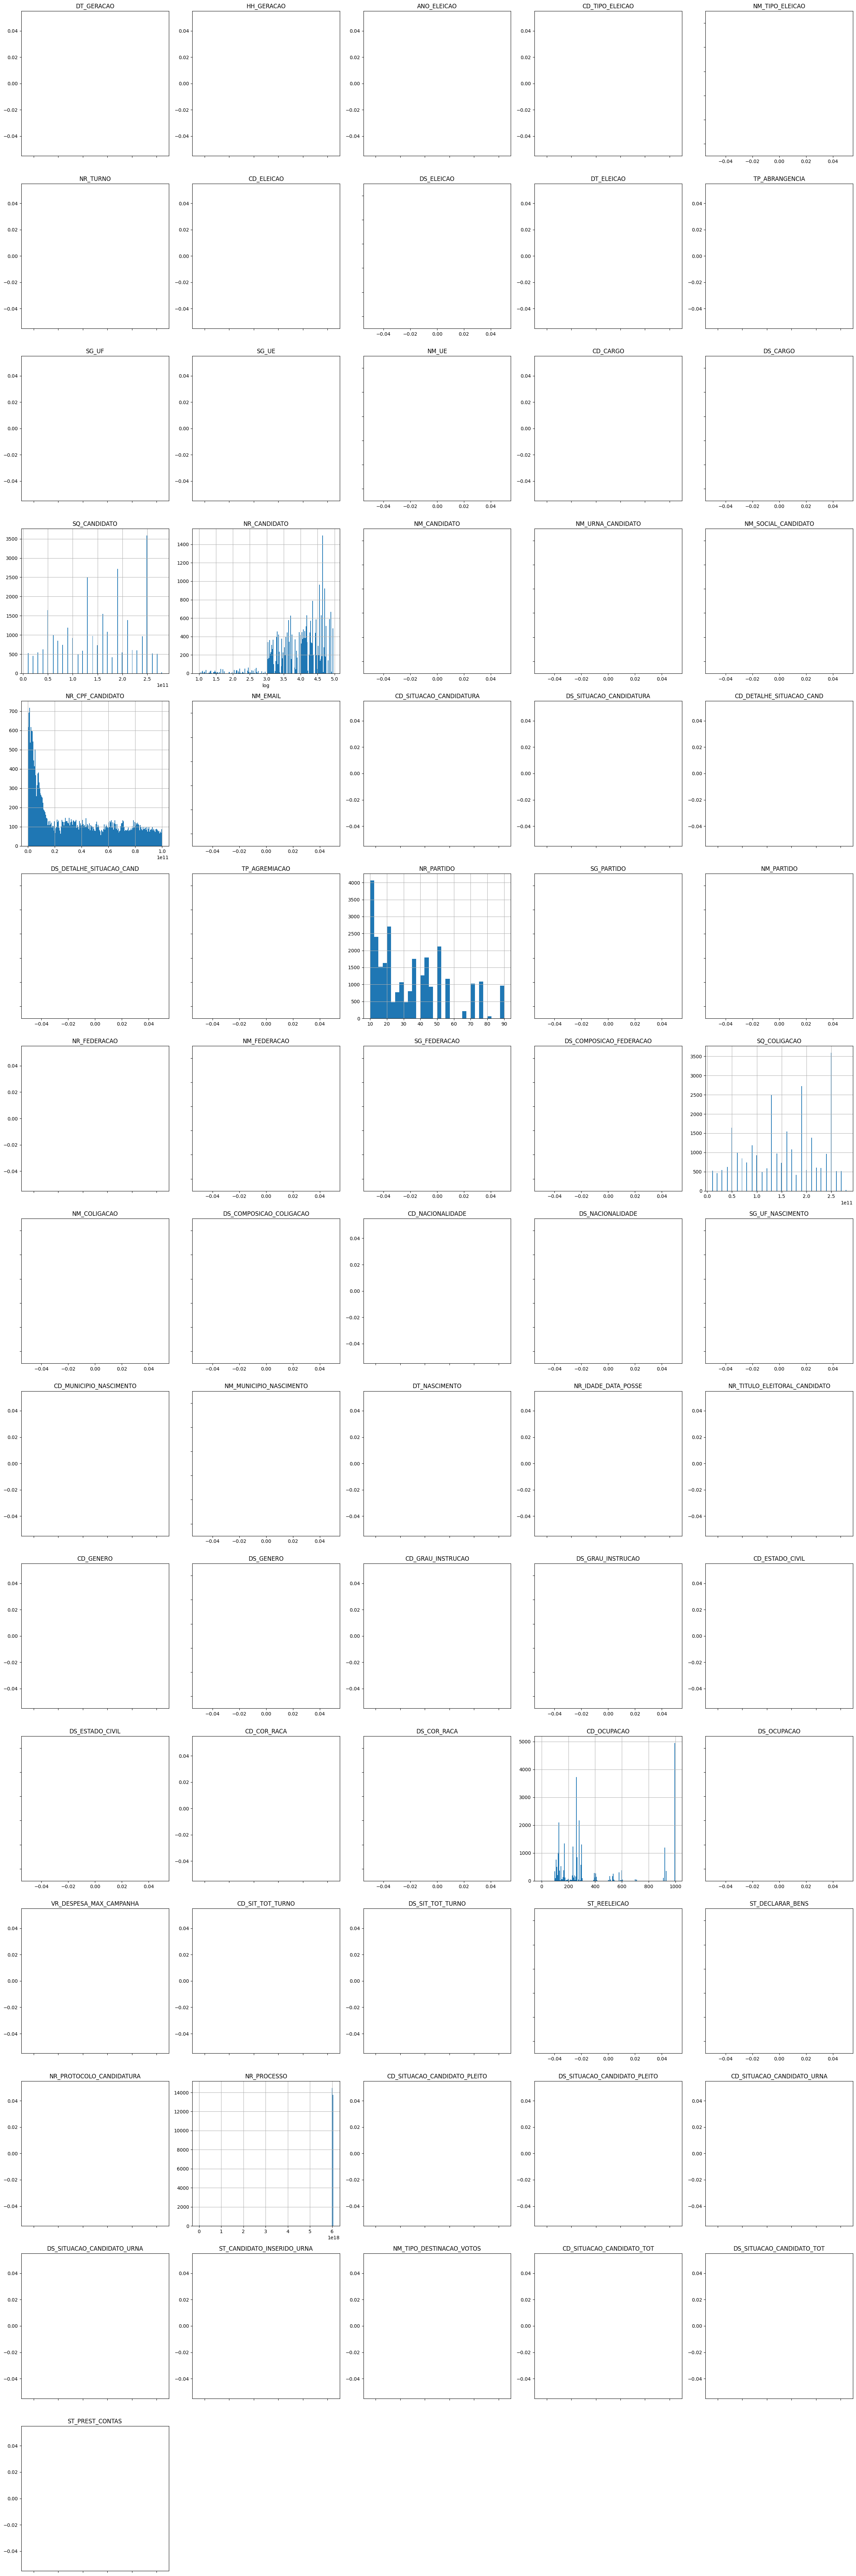

In [76]:
xe.multiple_dist_plots(cand22_df)